$\huge \text{Sentiment analysis on imdb dataset using LSTM.}$

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords
from collections import Counter
import string
import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import pickle

No Bottleneck unit testing available.


In [2]:
device=torch.device('cuda:0' if torch.cuda.is_available else 'cpu')

In [17]:
device='cpu'

In [3]:
base_csv = 'IMDB_Dataset.csv'
df = pd.read_csv(base_csv)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


$\huge \text{Splitting to train and test data}$

$\text{We will split data to train and test initially. Doing this on earlier stage allows to avoid data lekage.}$


In [4]:
X,y = df['review'].values,df['sentiment'].values
x_train,x_test,y_train,y_test = train_test_split(X,y,stratify=y)
print(f'shape of train data is {x_train.shape}')
print(f'shape of test data is {x_test.shape}')

shape of train data is (37500,)
shape of test data is (12500,)


$\huge \text{Tockenization}$

In [5]:
def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)

    return s

def tockenize(x_train,y_train,x_val,y_val):
    word_list = []

    stop_words = set(stopwords.words('english'))
    for sent in x_train:
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)

    corpus = Counter(word_list)
    # sorting on the basis of most common words
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:1000]
    # creating a dict
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}

    # tockenize
    final_list_train,final_list_test = [],[]
    for sent in x_train:
            final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split()
                                     if preprocess_string(word) in onehot_dict.keys()])
    for sent in x_val:
            final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split()
                                    if preprocess_string(word) in onehot_dict.keys()])

    encoded_train = [1 if label =='positive' else 0 for label in y_train]
    encoded_test = [1 if label =='positive' else 0 for label in y_val]
    return np.array(final_list_train,dtype=object), np.array(encoded_train),np.array(final_list_test,dtype=object), np.array(encoded_test),onehot_dict


In [6]:
x_train,y_train,x_test,y_test,vocab = tockenize(x_train,y_train,x_test,y_test)

In [7]:
print(f'Length of vocabulary is {len(vocab)}')

Length of vocabulary is 1000


$\huge \text{Padding}$

$\large \text{Now we will pad each of the sequence to max length}$

In [8]:
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

In [9]:

x_train_pad = padding_(x_train,500)
x_test_pad = padding_(x_test,500)


$\huge \text{Batching and loading as tensor}$

In [10]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test))

# dataloaders
batch_size = 50

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=False, batch_size=batch_size)
train_loader_acc=DataLoader(train_data, shuffle=False, batch_size=batch_size)

In [11]:
# obtain one batch of training data
for i,(sample_x,sample_y) in enumerate(train_loader):


  print('Sample input size: ', sample_x.size()) # batch_size, seq_length
  print('Sample input: \n', sample_x)
  print('Sample input: \n', sample_y)
  break

Sample input size:  torch.Size([50, 500])
Sample input: 
 tensor([[  0,   0,   0,  ...,  88, 389, 432],
        [  0,   0,   0,  ...,   4,  63, 593],
        [  0,   0,   0,  ..., 119, 647, 165],
        ...,
        [  0,   0,   0,  ..., 254,   9,  56],
        [  0,   0,   0,  ..., 143, 139, 301],
        [  0,   0,   0,  ..., 166,  30, 194]])
Sample input: 
 tensor([1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,
        1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0,
        0, 0])


In [26]:
# Define the RNN model
class RNN(nn.Module):
    def __init__(self, hidden_size, output_size,n_layers,embedding_dim):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers=n_layers
        self.rnn = nn.RNN(embedding_dim, hidden_size,n_layers,batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.relu=nn.ReLU()
        self.sigmoid=nn.Sigmoid()
        self.tanh=nn.Tanh()
        self.embed=nn.Embedding(len(vocab)+1,embedding_dim=embedding_dim)
    def forward(self, x):
        batch_size = x.size(0)
        # embeddings and lstm_out
        embeds = self.embed(x)
        print(embeds.shape)
        print(embeds[0])
        hidden=self.init_hidden(batch_size)

        # pass in the rnn layer
        out,hidden=self.rnn(embeds,hidden)
        # out=out.contiguous().view(-1,self.hidden_dim)
        # out=self.fc(out)



        output = self.sigmoid(self.fc(hidden.squeeze(0)))
        if self.n_layers==1:
            return output
        else:
            return output[-1]

    def init_hidden(self,batch_size):
        hidden=torch.zeros(self.n_layers,batch_size,self.hidden_size).to(device)
        return hidden

In [27]:
import torch.nn as nn

In [28]:
def train_acc(model):
    acc=0
    for instances,labels in train_loader_acc:
        
        output=model(instances.to(device))
        for i in range(len(output)):
            if output[i]>=0.5 and labels[i]==1:
                acc+=1
            elif output[i]<0.5 and labels[i]==0:
                acc+=1
    del instances
    del labels
    return acc/len(train_data)
def valid_acc(model):
    acc=0
    for instances,labels in valid_loader:
        
        output=model(instances.to(device))
        for i in range(len(output)):
            if output[i]>=0.5 and labels[i]==1:
                acc+=1
            elif output[i]<0.5 and labels[i]==0:
                acc+=1
    del instances
    del labels
    return acc/len(valid_data)



def train_loss(model,batch_size,criterion):
    loss=0
    for instances,labels in train_loader_acc:
        labels=labels.reshape(len(labels),-1).to(device).to(torch.float32)
        output=model(instances.to(device))
        loss+=criterion(output,labels)
    del instances
    del labels
    return loss/batch_size
def valid_loss(model,batch_size,criterion):
    loss=0
    for instances,labels in valid_loader:
        labels=labels.reshape(len(labels),-1).to(device).to(torch.float32)
        output=model(instances.to(device))
        loss+=criterion(output,labels)
    del instances
    del labels
    return loss/batch_size
    
        
        

In [29]:
hidden_size=100
output_size=1
n_layers=1
embedding_dim=64
model=RNN(hidden_size,output_size,n_layers,embedding_dim).to(device)
criterion =nn.BCELoss()
lr=0.0001
train_acc_list=[]
valid_acc_list=[]
loss_list=[]
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
epochs=100
num_epochs=tqdm(range(epochs))

# n_epochs=tqdm(range(epochs))
for epoch in num_epochs:

    running_loss = 0

    for i,(instances, labels) in enumerate(train_loader):

        optimizer.zero_grad()

        instances=instances.to(device)
        labels=labels.reshape(len(labels),-1).to(device).to(torch.float32)
        
        # print(instances.shape)
        output = model(instances)
        break
        # print(labels.shape)
        # print(output.shape)
        # print(output)

        # print(output.shape)
        # print(labels.shape)
        loss = criterion(output, labels)


        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    break
    loss_list.append(running_loss/batch_size)
    a=train_acc(model)
    train_acc_list.append(a)
    
    b=valid_acc(model)
    
    # print('accuracy over validation data set:',b)
    valid_acc_list.append(b)
    print('epoch is:',epoch+1,'accuracy over training/validation data set:',a,'/',b,' || running loss is:',running_loss/batch_size)
 


  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([50, 500, 64])
tensor([[-1.2220, -0.0928,  1.3138,  ..., -1.2016,  1.2841, -1.0755],
        [-1.2220, -0.0928,  1.3138,  ..., -1.2016,  1.2841, -1.0755],
        [-1.2220, -0.0928,  1.3138,  ..., -1.2016,  1.2841, -1.0755],
        ...,
        [-0.1663, -2.1743, -0.8525,  ...,  0.4931,  1.5228, -1.0987],
        [ 1.7749,  0.7776,  0.4049,  ..., -0.1792, -0.3736,  1.2558],
        [-1.7206, -1.1177, -0.0405,  ..., -0.2436,  0.6243, -0.7716]],
       grad_fn=<SelectBackward0>)


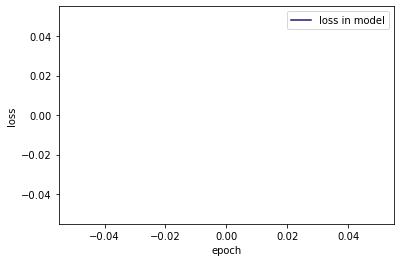

In [30]:
plt.plot(loss_list,label='loss in model',color='midnightblue')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

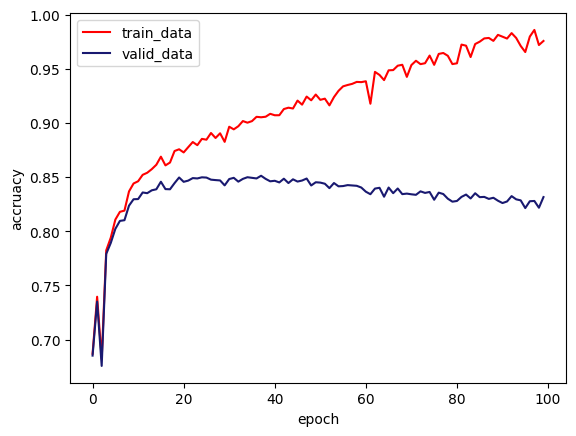

In [30]:
plt.plot(train_acc_list,label='train_data',color='red')
plt.plot(valid_acc_list,label='valid_data',color='midnightblue')
plt.xlabel('epoch')
plt.ylabel('accruacy')
plt.legend()
plt.show()

$\large \text{Now we do hyperparameter tuning of learning rate with different number of epochs: }$

In [ ]:
lr_list=[1e-5,5*1e-5,1e-4,5*1e-4,1e-3,5*1e-3,1e-2,5*1e-2,1e-1]
epochs_list=[1000,900,800,700,600,500,400,300,200]
hidden_size=100
output_size=1
n_layers=1
embedding_dim=64
train_accuracy=[]
test_accuracy=[]
print('Process starts from here :::')
for i in range(len(lr_list)):
    
    model=RNN(hidden_size,output_size,n_layers,embedding_dim).to(device)
    criterion =nn.BCELoss()
    lr=lr_list[i]
    train_acc_list=[]
    valid_acc_list=[]
    train_loss_list=[]
    valid_loss_list=[]
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    num_epochs=tqdm(range(epochs_list[i]))

    
    for epoch in num_epochs:

        running_loss = 0

        for i,(instances, labels) in enumerate(train_loader):

            optimizer.zero_grad()

            instances=instances.to(device)
            labels=labels.reshape(len(labels),-1).to(device).to(torch.float32)
    
            output = model(instances)

            
            loss = criterion(output, labels)


            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        a=train_acc(model)
        train_acc_list.append(a)
        b=valid_acc(model)
        
        valid_acc_list.append(b)
    train_accuracy.append(train_acc_list)
    test_accuracy.append(valid_acc_list)
    
dict_results={'lr':lr_list,'train_accuracy':train_accuracy,'test_accuracy':test_accuracy}

with open('/home/divya/sohan_p/RNN/RNN_lr_new.pkl', 'wb') as f:
    pickle.dump(dict_results, f)  
            

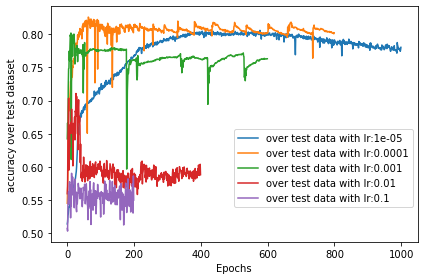

In [7]:

dict_results=pd.read_pickle('RNN_lr_new.pkl')
train_accuracy=dict_results['train_accuracy']
test_accuracy=dict_results['test_accuracy']
lr_list=dict_results['lr']
for i in range(0,len(train_accuracy),2):
    # plt.plot(train_accuracy[i],label=f'over train data with lr:{lr_list[i]}')
    plt.plot(test_accuracy[i],label=f'over test data with lr:{lr_list[i]}')
plt.legend(bbox_to_anchor=(1,0.5))
plt.xlabel('Epochs')
plt.ylabel('accuracy over test dataset')
plt.tight_layout()


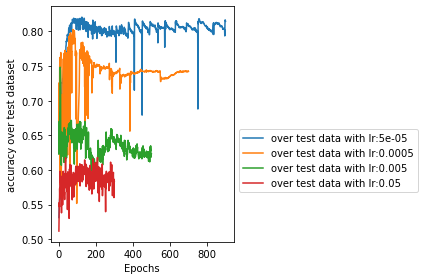

In [8]:
for i in range(1,len(train_accuracy),2):
    plt.plot(train_accuracy[i],label=f'over train data with lr:{lr_list[i]}')
    plt.plot(test_accuracy[i],label=f'over test data with lr:{lr_list[i]}')
plt.legend(bbox_to_anchor=(1,0.5))
plt.xlabel('Epochs')
plt.ylabel('accuracy over test dataset')
plt.tight_layout()

$\large \text{Here we can see that 0.0001 is the best learning rate for the model.}$

$\huge \text{Trying different number of layers:}$

In [31]:
hidden_size=100
output_size=1
n_layers=2
embedding_dim=64
model=RNN(hidden_size,output_size,n_layers,embedding_dim).to(device)
criterion =nn.BCELoss()
lr=0.0001
train_acc_list=[]
valid_acc_list=[]
loss_list=[]
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
epochs=100
num_epochs=tqdm(range(epochs))

# n_epochs=tqdm(range(epochs))
for epoch in num_epochs:

    running_loss = 0

    for i,(instances, labels) in enumerate(train_loader):

        optimizer.zero_grad()

        instances=instances.to(device)
        labels=labels.reshape(len(labels),-1).to(device).to(torch.float32)
        # print(instances.shape)
        output = model(instances)

        # print(labels.shape)
        # print(output.shape)
        # print(output)

        # print(output.shape)
        # print(labels.shape)
        loss = criterion(output, labels)


        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    loss_list.append(running_loss/batch_size)
    a=train_acc(model)
    train_acc_list.append(a)
    
    b=valid_acc(model)
    
    # print('accuracy over validation data set:',b)
    valid_acc_list.append(b)
    print('epoch is:',epoch+1,'accuracy over training/validation data set:',a,'/',b,' || running loss is:',running_loss/batch_size)
 


  0%|          | 0/100 [00:00<?, ?it/s]  1%|          | 1/100 [00:13<22:15, 13.49s/it]

epoch is: 1 accuracy over training/validation data set: 0.66872 / 0.67  || running loss is: 9.943030264377594


  2%|▏         | 2/100 [00:26<21:55, 13.42s/it]

epoch is: 2 accuracy over training/validation data set: 0.7029866666666666 / 0.702  || running loss is: 9.040539729595185


  3%|▎         | 3/100 [00:40<22:09, 13.70s/it]

epoch is: 3 accuracy over training/validation data set: 0.7531466666666666 / 0.7492  || running loss is: 8.148526062965393


  4%|▍         | 4/100 [00:54<21:58, 13.74s/it]

epoch is: 4 accuracy over training/validation data set: 0.7770133333333333 / 0.76856  || running loss is: 7.5575654363632205


  5%|▌         | 5/100 [01:03<19:05, 12.06s/it]

epoch is: 5 accuracy over training/validation data set: 0.7978133333333334 / 0.78464  || running loss is: 7.068032914400101


  6%|▌         | 6/100 [01:17<19:48, 12.64s/it]

epoch is: 6 accuracy over training/validation data set: 0.8075466666666666 / 0.79824  || running loss is: 6.644477548003197


  7%|▋         | 7/100 [01:33<21:14, 13.70s/it]

epoch is: 7 accuracy over training/validation data set: 0.81664 / 0.806  || running loss is: 6.318932182490825


  8%|▊         | 8/100 [01:46<20:53, 13.63s/it]

epoch is: 8 accuracy over training/validation data set: 0.8336533333333334 / 0.82048  || running loss is: 6.043221490979195


  9%|▉         | 9/100 [01:55<18:15, 12.04s/it]

epoch is: 9 accuracy over training/validation data set: 0.8385066666666666 / 0.82328  || running loss is: 5.7739451885223385


 10%|█         | 10/100 [02:04<16:35, 11.06s/it]

epoch is: 10 accuracy over training/validation data set: 0.8426933333333333 / 0.82648  || running loss is: 5.62142000079155


 11%|█         | 11/100 [02:14<15:52, 10.70s/it]

epoch is: 11 accuracy over training/validation data set: 0.8445866666666667 / 0.82488  || running loss is: 5.4625366869568825


 12%|█▏        | 12/100 [02:28<17:27, 11.91s/it]

epoch is: 12 accuracy over training/validation data set: 0.8580266666666667 / 0.8368  || running loss is: 5.3086464527249335


 13%|█▎        | 13/100 [02:42<18:12, 12.55s/it]

epoch is: 13 accuracy over training/validation data set: 0.8577333333333333 / 0.83984  || running loss is: 5.170123459398747


 14%|█▍        | 14/100 [02:56<18:36, 12.98s/it]

epoch is: 14 accuracy over training/validation data set: 0.8568266666666666 / 0.8328  || running loss is: 5.097365205436945


 15%|█▌        | 15/100 [03:10<18:50, 13.29s/it]

epoch is: 15 accuracy over training/validation data set: 0.86688 / 0.84456  || running loss is: 4.963001486361026


 16%|█▌        | 16/100 [03:24<18:44, 13.38s/it]

epoch is: 16 accuracy over training/validation data set: 0.87312 / 0.8472  || running loss is: 4.894241417348385


 17%|█▋        | 17/100 [03:38<18:36, 13.45s/it]

epoch is: 17 accuracy over training/validation data set: 0.8720266666666666 / 0.84552  || running loss is: 4.772005175948143


 18%|█▊        | 18/100 [03:51<18:30, 13.54s/it]

epoch is: 18 accuracy over training/validation data set: 0.8745066666666667 / 0.84032  || running loss is: 4.686323649585247


 19%|█▉        | 19/100 [04:05<18:14, 13.51s/it]

epoch is: 19 accuracy over training/validation data set: 0.87896 / 0.84928  || running loss is: 4.623260632902384


 20%|██        | 20/100 [04:26<21:04, 15.80s/it]

epoch is: 20 accuracy over training/validation data set: 0.8837333333333334 / 0.84736  || running loss is: 4.531250128298998


 21%|██        | 21/100 [04:46<22:33, 17.13s/it]

epoch is: 21 accuracy over training/validation data set: 0.8846666666666667 / 0.84696  || running loss is: 4.460380664765835


 22%|██▏       | 22/100 [05:07<23:37, 18.17s/it]

epoch is: 22 accuracy over training/validation data set: 0.8824266666666667 / 0.8432  || running loss is: 4.417825707644224


 23%|██▎       | 23/100 [05:26<23:52, 18.61s/it]

epoch is: 23 accuracy over training/validation data set: 0.8829866666666667 / 0.84136  || running loss is: 4.317813131809235


 24%|██▍       | 24/100 [05:44<23:18, 18.41s/it]

epoch is: 24 accuracy over training/validation data set: 0.8879466666666667 / 0.84312  || running loss is: 4.264074064344168


 25%|██▌       | 25/100 [06:02<22:48, 18.25s/it]

epoch is: 25 accuracy over training/validation data set: 0.8835466666666667 / 0.8396  || running loss is: 4.169132734090089


 26%|██▌       | 26/100 [06:22<23:01, 18.67s/it]

epoch is: 26 accuracy over training/validation data set: 0.8931466666666666 / 0.84712  || running loss is: 4.133907380700111


 27%|██▋       | 27/100 [06:40<22:38, 18.61s/it]

epoch is: 27 accuracy over training/validation data set: 0.89456 / 0.8424  || running loss is: 4.017038570195436


 28%|██▊       | 28/100 [06:58<21:55, 18.27s/it]

epoch is: 28 accuracy over training/validation data set: 0.9011466666666667 / 0.8464  || running loss is: 3.9810471080243586


 29%|██▉       | 29/100 [07:16<21:35, 18.25s/it]

epoch is: 29 accuracy over training/validation data set: 0.90032 / 0.84528  || running loss is: 3.908044646382332


 30%|███       | 30/100 [07:34<21:16, 18.24s/it]

epoch is: 30 accuracy over training/validation data set: 0.9062933333333333 / 0.84464  || running loss is: 3.8522872675955298


 31%|███       | 31/100 [07:48<19:17, 16.78s/it]

epoch is: 31 accuracy over training/validation data set: 0.89824 / 0.83872  || running loss is: 3.7800953930616377


 32%|███▏      | 32/100 [08:02<18:19, 16.17s/it]

epoch is: 32 accuracy over training/validation data set: 0.9106666666666666 / 0.8444  || running loss is: 3.673873118162155


 33%|███▎      | 33/100 [08:16<17:18, 15.51s/it]

epoch is: 33 accuracy over training/validation data set: 0.91088 / 0.84424  || running loss is: 3.6325122852623464


 34%|███▍      | 34/100 [08:30<16:27, 14.97s/it]

epoch is: 34 accuracy over training/validation data set: 0.8897866666666666 / 0.8376  || running loss is: 3.577372455894947


 35%|███▌      | 35/100 [08:44<15:50, 14.63s/it]

epoch is: 35 accuracy over training/validation data set: 0.9195466666666666 / 0.8416  || running loss is: 3.511803463548422


 36%|███▌      | 36/100 [08:58<15:20, 14.38s/it]

epoch is: 36 accuracy over training/validation data set: 0.9189333333333334 / 0.84024  || running loss is: 3.3686524902284147


 37%|███▋      | 37/100 [09:12<15:12, 14.49s/it]

epoch is: 37 accuracy over training/validation data set: 0.92296 / 0.84208  || running loss is: 3.3171933060884475


 38%|███▊      | 38/100 [09:26<14:34, 14.11s/it]

epoch is: 38 accuracy over training/validation data set: 0.92456 / 0.84312  || running loss is: 3.2443205547332763


 39%|███▉      | 39/100 [09:40<14:32, 14.31s/it]

epoch is: 39 accuracy over training/validation data set: 0.9312266666666666 / 0.84352  || running loss is: 3.1742544619739057


 40%|████      | 40/100 [09:59<15:36, 15.61s/it]

epoch is: 40 accuracy over training/validation data set: 0.9160533333333334 / 0.83832  || running loss is: 3.061959909722209


 41%|████      | 41/100 [10:16<15:51, 16.12s/it]

epoch is: 41 accuracy over training/validation data set: 0.9234933333333334 / 0.83672  || running loss is: 2.9991165512800215


 42%|████▏     | 42/100 [10:35<16:19, 16.89s/it]

epoch is: 42 accuracy over training/validation data set: 0.9330133333333334 / 0.83984  || running loss is: 2.9500529343634843


 43%|████▎     | 43/100 [10:52<16:05, 16.93s/it]

epoch is: 43 accuracy over training/validation data set: 0.94016 / 0.84104  || running loss is: 2.8670159815251828


 44%|████▍     | 44/100 [11:11<16:16, 17.45s/it]

epoch is: 44 accuracy over training/validation data set: 0.9332 / 0.83984  || running loss is: 2.8051357267796995


 45%|████▌     | 45/100 [11:29<16:13, 17.70s/it]

epoch is: 45 accuracy over training/validation data set: 0.9438666666666666 / 0.8392  || running loss is: 2.7114930660650134


 46%|████▌     | 46/100 [11:46<15:49, 17.59s/it]

epoch is: 46 accuracy over training/validation data set: 0.93536 / 0.83464  || running loss is: 2.644444918707013


 47%|████▋     | 47/100 [12:04<15:36, 17.67s/it]

epoch is: 47 accuracy over training/validation data set: 0.9446933333333334 / 0.83464  || running loss is: 2.5645543716102837


 48%|████▊     | 48/100 [12:19<14:33, 16.79s/it]

epoch is: 48 accuracy over training/validation data set: 0.9462933333333333 / 0.8368  || running loss is: 2.485492697879672


 49%|████▉     | 49/100 [12:38<14:52, 17.50s/it]

epoch is: 49 accuracy over training/validation data set: 0.9462666666666667 / 0.83504  || running loss is: 2.4164094043150546


 50%|█████     | 50/100 [12:59<15:24, 18.49s/it]

epoch is: 50 accuracy over training/validation data set: 0.9432266666666667 / 0.82912  || running loss is: 2.3498912673071026


 51%|█████     | 51/100 [13:21<15:59, 19.57s/it]

epoch is: 51 accuracy over training/validation data set: 0.9537866666666667 / 0.83608  || running loss is: 2.306397807635367


 52%|█████▏    | 52/100 [13:45<16:42, 20.88s/it]

epoch is: 52 accuracy over training/validation data set: 0.9448533333333333 / 0.83272  || running loss is: 2.2037991474941374


 53%|█████▎    | 53/100 [14:07<16:44, 21.36s/it]

epoch is: 53 accuracy over training/validation data set: 0.9578133333333333 / 0.83688  || running loss is: 2.103521052338183


 54%|█████▍    | 54/100 [14:29<16:26, 21.45s/it]

epoch is: 54 accuracy over training/validation data set: 0.9602666666666667 / 0.83176  || running loss is: 2.139094938337803


 55%|█████▌    | 55/100 [14:49<15:46, 21.04s/it]

epoch is: 55 accuracy over training/validation data set: 0.9450933333333333 / 0.83032  || running loss is: 1.9206705148145558


 56%|█████▌    | 56/100 [15:08<14:59, 20.44s/it]

epoch is: 56 accuracy over training/validation data set: 0.96088 / 0.8324  || running loss is: 1.9156621811538934


 57%|█████▋    | 57/100 [15:26<14:10, 19.77s/it]

epoch is: 57 accuracy over training/validation data set: 0.95536 / 0.82656  || running loss is: 1.867349855005741


 58%|█████▊    | 58/100 [15:43<13:05, 18.70s/it]

epoch is: 58 accuracy over training/validation data set: 0.97024 / 0.83544  || running loss is: 1.793762907013297


 59%|█████▉    | 59/100 [16:00<12:27, 18.23s/it]

epoch is: 59 accuracy over training/validation data set: 0.9660266666666667 / 0.83304  || running loss is: 1.7198828302696347


 60%|██████    | 60/100 [16:16<11:47, 17.68s/it]

epoch is: 60 accuracy over training/validation data set: 0.9615733333333333 / 0.82624  || running loss is: 1.8631631866842508


 61%|██████    | 61/100 [16:32<11:13, 17.26s/it]

epoch is: 61 accuracy over training/validation data set: 0.9753866666666666 / 0.8276  || running loss is: 1.6025813039578498


 62%|██████▏   | 62/100 [16:49<10:45, 16.99s/it]

epoch is: 62 accuracy over training/validation data set: 0.97352 / 0.83272  || running loss is: 1.522977148424834


 63%|██████▎   | 63/100 [17:05<10:22, 16.83s/it]

epoch is: 63 accuracy over training/validation data set: 0.9725866666666667 / 0.82336  || running loss is: 1.443069700859487


 64%|██████▍   | 64/100 [17:24<10:25, 17.38s/it]

epoch is: 64 accuracy over training/validation data set: 0.9755733333333333 / 0.83208  || running loss is: 1.4554974251426755


 65%|██████▌   | 65/100 [17:43<10:31, 18.03s/it]

epoch is: 65 accuracy over training/validation data set: 0.98144 / 0.83056  || running loss is: 1.3028900797106326


 66%|██████▌   | 66/100 [18:04<10:39, 18.81s/it]

epoch is: 66 accuracy over training/validation data set: 0.9817866666666667 / 0.8256  || running loss is: 1.2912830369360746


 67%|██████▋   | 67/100 [18:26<10:53, 19.81s/it]

epoch is: 67 accuracy over training/validation data set: 0.9763466666666667 / 0.82656  || running loss is: 1.222599408859387


 68%|██████▊   | 68/100 [18:45<10:28, 19.64s/it]

epoch is: 68 accuracy over training/validation data set: 0.9767733333333334 / 0.83024  || running loss is: 1.3074179275333881


 69%|██████▉   | 69/100 [19:06<10:18, 19.97s/it]

epoch is: 69 accuracy over training/validation data set: 0.9781066666666667 / 0.82464  || running loss is: 1.1031826761178671


 70%|███████   | 70/100 [19:28<10:15, 20.51s/it]

epoch is: 70 accuracy over training/validation data set: 0.9874666666666667 / 0.82552  || running loss is: 1.2989465925097465


 71%|███████   | 71/100 [19:51<10:13, 21.15s/it]

epoch is: 71 accuracy over training/validation data set: 0.9882933333333334 / 0.8288  || running loss is: 0.9548828973155469


 72%|███████▏  | 72/100 [20:13<10:01, 21.48s/it]

epoch is: 72 accuracy over training/validation data set: 0.99016 / 0.82344  || running loss is: 1.059415739327669


 73%|███████▎  | 73/100 [20:34<09:38, 21.43s/it]

epoch is: 73 accuracy over training/validation data set: 0.98224 / 0.82832  || running loss is: 1.001388404709287


 74%|███████▍  | 74/100 [20:58<09:36, 22.16s/it]

epoch is: 74 accuracy over training/validation data set: 0.9835733333333333 / 0.82664  || running loss is: 0.8442232902627438


 75%|███████▌  | 75/100 [21:21<09:22, 22.51s/it]

epoch is: 75 accuracy over training/validation data set: 0.98888 / 0.82936  || running loss is: 1.0977728686574846


 76%|███████▌  | 76/100 [21:43<08:52, 22.18s/it]

epoch is: 76 accuracy over training/validation data set: 0.9853066666666667 / 0.82704  || running loss is: 0.7347245273552835


 77%|███████▋  | 77/100 [22:03<08:14, 21.52s/it]

epoch is: 77 accuracy over training/validation data set: 0.98184 / 0.82144  || running loss is: 0.8539938965719194


 78%|███████▊  | 78/100 [22:21<07:30, 20.48s/it]

epoch is: 78 accuracy over training/validation data set: 0.9918133333333333 / 0.82408  || running loss is: 1.0691954662837089


 79%|███████▉  | 79/100 [22:37<06:44, 19.24s/it]

epoch is: 79 accuracy over training/validation data set: 0.9939733333333334 / 0.82296  || running loss is: 0.7655004838947207


 80%|████████  | 80/100 [22:53<06:04, 18.24s/it]

epoch is: 80 accuracy over training/validation data set: 0.9893066666666667 / 0.82488  || running loss is: 0.7915578451147303


 81%|████████  | 81/100 [23:10<05:40, 17.91s/it]

epoch is: 81 accuracy over training/validation data set: 0.9828 / 0.82296  || running loss is: 0.6389947586227208


 82%|████████▏ | 82/100 [23:25<05:03, 16.88s/it]

epoch is: 82 accuracy over training/validation data set: 0.9881066666666667 / 0.82152  || running loss is: 0.7306047046510503


 83%|████████▎ | 83/100 [23:42<04:50, 17.08s/it]

epoch is: 83 accuracy over training/validation data set: 0.9944266666666667 / 0.82544  || running loss is: 0.802097122175619


 84%|████████▍ | 84/100 [24:00<04:38, 17.43s/it]

epoch is: 84 accuracy over training/validation data set: 0.9872 / 0.8236  || running loss is: 0.6986907391925342


 85%|████████▌ | 85/100 [24:21<04:35, 18.35s/it]

epoch is: 85 accuracy over training/validation data set: 0.9954133333333334 / 0.8208  || running loss is: 0.6015824240376242


 86%|████████▌ | 86/100 [24:41<04:23, 18.83s/it]

epoch is: 86 accuracy over training/validation data set: 0.9875733333333333 / 0.82048  || running loss is: 0.6920509994425811


 87%|████████▋ | 87/100 [25:02<04:13, 19.49s/it]

epoch is: 87 accuracy over training/validation data set: 0.9900533333333333 / 0.82144  || running loss is: 0.7309561620582826


 88%|████████▊ | 88/100 [25:25<04:05, 20.47s/it]

epoch is: 88 accuracy over training/validation data set: 0.9922666666666666 / 0.81952  || running loss is: 0.47813055582810193


 89%|████████▉ | 89/100 [25:48<03:55, 21.45s/it]

epoch is: 89 accuracy over training/validation data set: 0.9960533333333333 / 0.82128  || running loss is: 0.41610436514019966


 90%|█████████ | 90/100 [26:11<03:38, 21.89s/it]

epoch is: 90 accuracy over training/validation data set: 0.9932533333333333 / 0.82032  || running loss is: 0.7916517617134378


 91%|█████████ | 91/100 [26:33<03:17, 21.89s/it]

epoch is: 91 accuracy over training/validation data set: 0.9965866666666666 / 0.82088  || running loss is: 0.35584754615905695


 92%|█████████▏| 92/100 [26:54<02:51, 21.44s/it]

epoch is: 92 accuracy over training/validation data set: 0.99456 / 0.8224  || running loss is: 0.6164210323360748


 93%|█████████▎| 93/100 [27:12<02:24, 20.67s/it]

epoch is: 93 accuracy over training/validation data set: 0.9970933333333334 / 0.824  || running loss is: 0.492583487466909


 94%|█████████▍| 94/100 [27:29<01:56, 19.50s/it]

epoch is: 94 accuracy over training/validation data set: 0.99768 / 0.82184  || running loss is: 0.37559778162511065


 95%|█████████▌| 95/100 [27:45<01:32, 18.50s/it]

epoch is: 95 accuracy over training/validation data set: 0.9958133333333333 / 0.82056  || running loss is: 0.7099123336654156


 96%|█████████▌| 96/100 [28:05<01:15, 18.83s/it]

epoch is: 96 accuracy over training/validation data set: 0.99504 / 0.82368  || running loss is: 0.5365350491984282


 97%|█████████▋| 97/100 [28:24<00:56, 18.88s/it]

epoch is: 97 accuracy over training/validation data set: 0.9974666666666666 / 0.81976  || running loss is: 0.2574155042134225


 98%|█████████▊| 98/100 [28:45<00:38, 19.38s/it]

epoch is: 98 accuracy over training/validation data set: 0.9926933333333333 / 0.82296  || running loss is: 0.5864276393922045


 99%|█████████▉| 99/100 [29:05<00:19, 19.69s/it]

epoch is: 99 accuracy over training/validation data set: 0.9896 / 0.81808  || running loss is: 0.5219394128536805


100%|██████████| 100/100 [29:26<00:00, 17.66s/it]

epoch is: 100 accuracy over training/validation data set: 0.99712 / 0.82344  || running loss is: 0.5396221433905884


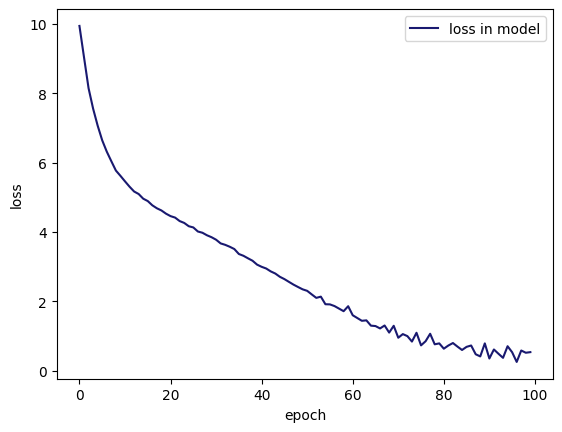

In [32]:
plt.plot(loss_list,label='loss in model',color='midnightblue')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

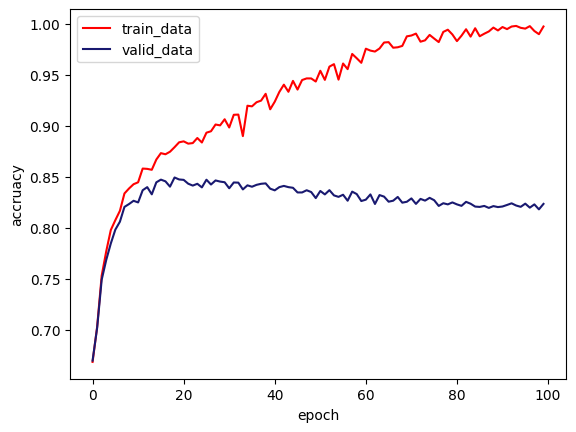

In [33]:
plt.plot(train_acc_list,label='train_data',color='red')
plt.plot(valid_acc_list,label='valid_data',color='midnightblue')
plt.xlabel('epoch')
plt.ylabel('accruacy')
plt.legend()
plt.show()

$\large \text{Using differenet embedding dimensions:}$

In [34]:
hidden_size=100
output_size=1
n_layers=1
embedding_dim=256
model=RNN(hidden_size,output_size,n_layers,embedding_dim).to(device)
criterion =nn.BCELoss()
lr=0.0001
train_acc_list=[]
valid_acc_list=[]
loss_list=[]
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
epochs=100
num_epochs=tqdm(range(epochs))

# n_epochs=tqdm(range(epochs))
for epoch in num_epochs:

    running_loss = 0

    for i,(instances, labels) in enumerate(train_loader):

        optimizer.zero_grad()

        instances=instances.to(device)
        labels=labels.reshape(len(labels),-1).to(device).to(torch.float32)
        # print(instances.shape)
        output = model(instances)

        # print(labels.shape)
        # print(output.shape)
        # print(output)

        # print(output.shape)
        # print(labels.shape)
        loss = criterion(output, labels)


        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    loss_list.append(running_loss/batch_size)
    a=train_acc(model)
    train_acc_list.append(a)
    
    b=valid_acc(model)
    
    # print('accuracy over validation data set:',b)
    valid_acc_list.append(b)
    print('epoch is:',epoch+1,'accuracy over training/validation data set:',a,'/',b,' || running loss is:',running_loss/batch_size)
 


  0%|          | 0/100 [00:00<?, ?it/s]  1%|          | 1/100 [00:22<37:36, 22.79s/it]

epoch is: 1 accuracy over training/validation data set: 0.6693866666666667 / 0.6656  || running loss is: 10.066012741327286


  2%|▏         | 2/100 [00:45<37:22, 22.89s/it]

epoch is: 2 accuracy over training/validation data set: 0.8081866666666667 / 0.79936  || running loss is: 7.491732774972916


  3%|▎         | 3/100 [01:01<31:53, 19.73s/it]

epoch is: 3 accuracy over training/validation data set: 0.82776 / 0.812  || running loss is: 6.4210525459051135


  4%|▍         | 4/100 [01:20<31:14, 19.53s/it]

epoch is: 4 accuracy over training/validation data set: 0.8345866666666667 / 0.8204  || running loss is: 5.885620776414871


  5%|▌         | 5/100 [01:39<30:17, 19.13s/it]

epoch is: 5 accuracy over training/validation data set: 0.8572266666666667 / 0.8328  || running loss is: 5.601426484882832


  6%|▌         | 6/100 [01:59<30:28, 19.45s/it]

epoch is: 6 accuracy over training/validation data set: 0.86216 / 0.8352  || running loss is: 5.246624541580677


  7%|▋         | 7/100 [02:18<30:09, 19.45s/it]

epoch is: 7 accuracy over training/validation data set: 0.8730933333333334 / 0.84224  || running loss is: 5.018111093342304


  8%|▊         | 8/100 [02:38<29:53, 19.50s/it]

epoch is: 8 accuracy over training/validation data set: 0.87856 / 0.84368  || running loss is: 4.817061221301556


  9%|▉         | 9/100 [02:57<29:13, 19.27s/it]

epoch is: 9 accuracy over training/validation data set: 0.8701066666666667 / 0.83704  || running loss is: 4.661580051928759


 10%|█         | 10/100 [03:12<27:14, 18.16s/it]

epoch is: 10 accuracy over training/validation data set: 0.88128 / 0.84192  || running loss is: 4.55867700740695


 11%|█         | 11/100 [03:29<26:01, 17.55s/it]

epoch is: 11 accuracy over training/validation data set: 0.8901866666666667 / 0.84672  || running loss is: 4.3890479063987735


 12%|█▏        | 12/100 [03:45<25:21, 17.30s/it]

epoch is: 12 accuracy over training/validation data set: 0.8898666666666667 / 0.84288  || running loss is: 4.222705011516809


 13%|█▎        | 13/100 [04:02<24:39, 17.01s/it]

epoch is: 13 accuracy over training/validation data set: 0.8944533333333333 / 0.84464  || running loss is: 4.164046566486359


 14%|█▍        | 14/100 [04:18<24:16, 16.94s/it]

epoch is: 14 accuracy over training/validation data set: 0.90384 / 0.84608  || running loss is: 4.024302639365196


 15%|█▌        | 15/100 [04:35<23:38, 16.69s/it]

epoch is: 15 accuracy over training/validation data set: 0.9053333333333333 / 0.84672  || running loss is: 3.899075242727995


 16%|█▌        | 16/100 [04:50<22:57, 16.40s/it]

epoch is: 16 accuracy over training/validation data set: 0.91216 / 0.84688  || running loss is: 3.8342296427488325


 17%|█▋        | 17/100 [05:07<22:47, 16.48s/it]

epoch is: 17 accuracy over training/validation data set: 0.9147733333333333 / 0.85024  || running loss is: 3.672472205162048


 18%|█▊        | 18/100 [05:23<22:18, 16.33s/it]

epoch is: 18 accuracy over training/validation data set: 0.9148266666666667 / 0.84488  || running loss is: 3.6172200940549373


 19%|█▉        | 19/100 [05:38<21:33, 15.97s/it]

epoch is: 19 accuracy over training/validation data set: 0.9204266666666666 / 0.84592  || running loss is: 3.4671839202195405


 20%|██        | 20/100 [05:53<20:47, 15.60s/it]

epoch is: 20 accuracy over training/validation data set: 0.9249333333333334 / 0.84904  || running loss is: 3.3740525844693185


 21%|██        | 21/100 [06:11<21:33, 16.38s/it]

epoch is: 21 accuracy over training/validation data set: 0.9282666666666667 / 0.84776  || running loss is: 3.240683104619384


 22%|██▏       | 22/100 [06:28<21:25, 16.49s/it]

epoch is: 22 accuracy over training/validation data set: 0.9270666666666667 / 0.8456  || running loss is: 3.163267461359501


 23%|██▎       | 23/100 [06:44<21:12, 16.53s/it]

epoch is: 23 accuracy over training/validation data set: 0.93544 / 0.84704  || running loss is: 3.1231624978780745


 24%|██▍       | 24/100 [07:00<20:32, 16.22s/it]

epoch is: 24 accuracy over training/validation data set: 0.9325866666666667 / 0.8444  || running loss is: 2.944190749078989


 25%|██▌       | 25/100 [07:15<19:58, 15.98s/it]

epoch is: 25 accuracy over training/validation data set: 0.94032 / 0.84536  || running loss is: 2.8288445819914343


 26%|██▌       | 26/100 [07:30<19:16, 15.63s/it]

epoch is: 26 accuracy over training/validation data set: 0.9389333333333333 / 0.84  || running loss is: 2.732037902623415


 27%|██▋       | 27/100 [07:46<19:03, 15.67s/it]

epoch is: 27 accuracy over training/validation data set: 0.94408 / 0.84416  || running loss is: 2.651141314357519


 28%|██▊       | 28/100 [08:01<18:47, 15.66s/it]

epoch is: 28 accuracy over training/validation data set: 0.9487466666666666 / 0.84432  || running loss is: 2.559953017421067


 29%|██▉       | 29/100 [08:17<18:23, 15.55s/it]

epoch is: 29 accuracy over training/validation data set: 0.9488266666666667 / 0.8416  || running loss is: 2.4228275536000727


 30%|███       | 30/100 [08:32<18:08, 15.54s/it]

epoch is: 30 accuracy over training/validation data set: 0.9536533333333334 / 0.8444  || running loss is: 2.355059837885201


 31%|███       | 31/100 [08:49<18:18, 15.92s/it]

epoch is: 31 accuracy over training/validation data set: 0.9589333333333333 / 0.84504  || running loss is: 2.239524732083082


 32%|███▏      | 32/100 [09:06<18:28, 16.30s/it]

epoch is: 32 accuracy over training/validation data set: 0.9544266666666666 / 0.83752  || running loss is: 2.1631790605932473


 33%|███▎      | 33/100 [09:27<19:43, 17.67s/it]

epoch is: 33 accuracy over training/validation data set: 0.9605866666666667 / 0.83848  || running loss is: 2.0178789291903376


 34%|███▍      | 34/100 [09:49<20:55, 19.03s/it]

epoch is: 34 accuracy over training/validation data set: 0.9574933333333333 / 0.83512  || running loss is: 1.9237614971399308


 35%|███▌      | 35/100 [10:11<21:34, 19.91s/it]

epoch is: 35 accuracy over training/validation data set: 0.9618666666666666 / 0.83832  || running loss is: 1.897149666044861


 36%|███▌      | 36/100 [10:31<21:08, 19.82s/it]

epoch is: 36 accuracy over training/validation data set: 0.97088 / 0.83928  || running loss is: 1.8031639767251908


 37%|███▋      | 37/100 [10:51<20:49, 19.83s/it]

epoch is: 37 accuracy over training/validation data set: 0.9718933333333334 / 0.8368  || running loss is: 1.7571734166517854


 38%|███▊      | 38/100 [11:11<20:34, 19.91s/it]

epoch is: 38 accuracy over training/validation data set: 0.9686666666666667 / 0.838  || running loss is: 1.607037098724395


 39%|███▉      | 39/100 [11:31<20:14, 19.91s/it]

epoch is: 39 accuracy over training/validation data set: 0.97472 / 0.83616  || running loss is: 1.55529150377959


 40%|████      | 40/100 [11:47<18:42, 18.71s/it]

epoch is: 40 accuracy over training/validation data set: 0.9733866666666666 / 0.83528  || running loss is: 1.427549519110471


 41%|████      | 41/100 [12:05<18:17, 18.61s/it]

epoch is: 41 accuracy over training/validation data set: 0.9773066666666667 / 0.8352  || running loss is: 1.4459717707894741


 42%|████▏     | 42/100 [12:23<17:41, 18.31s/it]

epoch is: 42 accuracy over training/validation data set: 0.9826666666666667 / 0.83584  || running loss is: 1.2869462365284563


 43%|████▎     | 43/100 [12:40<16:59, 17.88s/it]

epoch is: 43 accuracy over training/validation data set: 0.9828266666666666 / 0.8376  || running loss is: 1.3436305144429206


 44%|████▍     | 44/100 [12:56<16:09, 17.32s/it]

epoch is: 44 accuracy over training/validation data set: 0.98368 / 0.83312  || running loss is: 1.1439619356021284


 45%|████▌     | 45/100 [13:08<14:39, 15.99s/it]

epoch is: 45 accuracy over training/validation data set: 0.9868533333333334 / 0.83712  || running loss is: 1.0747927985806018


 46%|████▌     | 46/100 [13:24<14:15, 15.84s/it]

epoch is: 46 accuracy over training/validation data set: 0.9768533333333334 / 0.83112  || running loss is: 1.0710039696469904


 47%|████▋     | 47/100 [13:41<14:16, 16.16s/it]

epoch is: 47 accuracy over training/validation data set: 0.9869066666666667 / 0.8344  || running loss is: 1.104456798620522


 48%|████▊     | 48/100 [14:00<14:40, 16.93s/it]

epoch is: 48 accuracy over training/validation data set: 0.98784 / 0.83416  || running loss is: 1.054111470365897


 49%|████▉     | 49/100 [14:17<14:36, 17.19s/it]

epoch is: 49 accuracy over training/validation data set: 0.9771733333333333 / 0.83016  || running loss is: 0.938845884213224


 50%|█████     | 50/100 [14:34<14:15, 17.11s/it]

epoch is: 50 accuracy over training/validation data set: 0.9884 / 0.83144  || running loss is: 0.9141146758571267


 51%|█████     | 51/100 [14:51<13:56, 17.08s/it]

epoch is: 51 accuracy over training/validation data set: 0.98784 / 0.83216  || running loss is: 0.8830020931269974


 52%|█████▏    | 52/100 [15:08<13:38, 17.05s/it]

epoch is: 52 accuracy over training/validation data set: 0.9807733333333334 / 0.82688  || running loss is: 0.7631363445380702


 53%|█████▎    | 53/100 [15:24<13:07, 16.75s/it]

epoch is: 53 accuracy over training/validation data set: 0.9925866666666666 / 0.83064  || running loss is: 0.6904443453857675


 54%|█████▍    | 54/100 [15:40<12:32, 16.36s/it]

epoch is: 54 accuracy over training/validation data set: 0.9922133333333333 / 0.83008  || running loss is: 0.7488117137830704


 55%|█████▌    | 55/100 [15:55<12:05, 16.12s/it]

epoch is: 55 accuracy over training/validation data set: 0.9912533333333333 / 0.83376  || running loss is: 0.7525154723366723


 56%|█████▌    | 56/100 [16:13<12:04, 16.46s/it]

epoch is: 56 accuracy over training/validation data set: 0.9894933333333333 / 0.83328  || running loss is: 0.8155476125376299


 57%|█████▋    | 57/100 [16:26<11:04, 15.46s/it]

epoch is: 57 accuracy over training/validation data set: 0.9950933333333334 / 0.83416  || running loss is: 0.7228350650146603


 58%|█████▊    | 58/100 [16:41<10:41, 15.28s/it]

epoch is: 58 accuracy over training/validation data set: 0.99104 / 0.83184  || running loss is: 0.5087050055200234


 59%|█████▉    | 59/100 [16:56<10:24, 15.24s/it]

epoch is: 59 accuracy over training/validation data set: 0.9959733333333334 / 0.8304  || running loss is: 0.4734015908325091


 60%|██████    | 60/100 [17:10<09:57, 14.95s/it]

epoch is: 60 accuracy over training/validation data set: 0.9918666666666667 / 0.83096  || running loss is: 0.629803338474594


 61%|██████    | 61/100 [17:24<09:34, 14.73s/it]

epoch is: 61 accuracy over training/validation data set: 0.99568 / 0.82624  || running loss is: 0.35904682368272917


 62%|██████▏   | 62/100 [17:39<09:22, 14.80s/it]

epoch is: 62 accuracy over training/validation data set: 0.8737333333333334 / 0.77144  || running loss is: 0.960321117984131


 63%|██████▎   | 63/100 [17:55<09:14, 14.98s/it]

epoch is: 63 accuracy over training/validation data set: 0.9967733333333333 / 0.83176  || running loss is: 0.8531340686720796


 64%|██████▍   | 64/100 [18:08<08:46, 14.62s/it]

epoch is: 64 accuracy over training/validation data set: 0.9977066666666666 / 0.82944  || running loss is: 0.3345585822477005


 65%|██████▌   | 65/100 [18:23<08:31, 14.62s/it]

epoch is: 65 accuracy over training/validation data set: 0.9803466666666667 / 0.82832  || running loss is: 0.33876544212922455


 66%|██████▌   | 66/100 [18:38<08:19, 14.68s/it]

epoch is: 66 accuracy over training/validation data set: 0.9976 / 0.83208  || running loss is: 0.6085723840934224


 67%|██████▋   | 67/100 [18:54<08:22, 15.23s/it]

epoch is: 67 accuracy over training/validation data set: 0.99776 / 0.83248  || running loss is: 0.24998001736938022


 68%|██████▊   | 68/100 [19:13<08:43, 16.35s/it]

epoch is: 68 accuracy over training/validation data set: 0.99544 / 0.82896  || running loss is: 0.7539197372226044


 69%|██████▉   | 69/100 [19:32<08:52, 17.17s/it]

epoch is: 69 accuracy over training/validation data set: 0.9984 / 0.83016  || running loss is: 0.27505120771122166


 70%|███████   | 70/100 [19:51<08:48, 17.63s/it]

epoch is: 70 accuracy over training/validation data set: 0.9875733333333333 / 0.82824  || running loss is: 0.2820190617570188


 71%|███████   | 71/100 [20:10<08:41, 17.99s/it]

epoch is: 71 accuracy over training/validation data set: 0.9964 / 0.83072  || running loss is: 0.7603485840803478


 72%|███████▏  | 72/100 [20:29<08:34, 18.37s/it]

epoch is: 72 accuracy over training/validation data set: 0.9984533333333333 / 0.83024  || running loss is: 0.3058292822726071


 73%|███████▎  | 73/100 [20:45<07:58, 17.70s/it]

epoch is: 73 accuracy over training/validation data set: 0.9987466666666667 / 0.83192  || running loss is: 0.1810534304671455


 74%|███████▍  | 74/100 [21:02<07:32, 17.39s/it]

epoch is: 74 accuracy over training/validation data set: 0.99016 / 0.82256  || running loss is: 0.37175766528351234


 75%|███████▌  | 75/100 [21:20<07:18, 17.56s/it]

epoch is: 75 accuracy over training/validation data set: 0.9937333333333334 / 0.82672  || running loss is: 0.4110607928643003


 76%|███████▌  | 76/100 [21:34<06:38, 16.62s/it]

epoch is: 76 accuracy over training/validation data set: 0.9981333333333333 / 0.82712  || running loss is: 0.3340876482659951


 77%|███████▋  | 77/100 [21:51<06:20, 16.56s/it]

epoch is: 77 accuracy over training/validation data set: 0.9990133333333333 / 0.82936  || running loss is: 0.330062022160273


 78%|███████▊  | 78/100 [22:09<06:17, 17.15s/it]

epoch is: 78 accuracy over training/validation data set: 0.99872 / 0.82784  || running loss is: 0.14379373156873043


 79%|███████▉  | 79/100 [22:25<05:51, 16.75s/it]

epoch is: 79 accuracy over training/validation data set: 0.97912 / 0.82632  || running loss is: 0.5192445533862338


 80%|████████  | 80/100 [22:42<05:35, 16.77s/it]

epoch is: 80 accuracy over training/validation data set: 0.9922666666666666 / 0.82856  || running loss is: 0.3236275753960945


 81%|████████  | 81/100 [22:58<05:16, 16.65s/it]

epoch is: 81 accuracy over training/validation data set: 0.9991733333333334 / 0.83208  || running loss is: 0.5304105503996834


 82%|████████▏ | 82/100 [23:15<04:58, 16.61s/it]

epoch is: 82 accuracy over training/validation data set: 0.9994933333333333 / 0.8312  || running loss is: 0.11121761838789097


 83%|████████▎ | 83/100 [23:32<04:44, 16.75s/it]

epoch is: 83 accuracy over training/validation data set: 0.9985866666666666 / 0.83072  || running loss is: 0.4640619087015512


 84%|████████▍ | 84/100 [23:51<04:38, 17.40s/it]

epoch is: 84 accuracy over training/validation data set: 0.99936 / 0.83136  || running loss is: 0.19777344089001417


 85%|████████▌ | 85/100 [24:10<04:28, 17.89s/it]

epoch is: 85 accuracy over training/validation data set: 0.9926666666666667 / 0.8272  || running loss is: 0.2301643709803466


 86%|████████▌ | 86/100 [24:29<04:15, 18.25s/it]

epoch is: 86 accuracy over training/validation data set: 0.9874666666666667 / 0.82208  || running loss is: 0.26767983403697143


 87%|████████▋ | 87/100 [24:46<03:52, 17.88s/it]

epoch is: 87 accuracy over training/validation data set: 0.99944 / 0.83128  || running loss is: 0.3868669461290119


 88%|████████▊ | 88/100 [25:04<03:36, 18.08s/it]

epoch is: 88 accuracy over training/validation data set: 0.9997066666666666 / 0.82984  || running loss is: 0.08170756879728287


 89%|████████▉ | 89/100 [25:20<03:10, 17.32s/it]

epoch is: 89 accuracy over training/validation data set: 0.9998133333333333 / 0.82944  || running loss is: 0.05970468103099847


 90%|█████████ | 90/100 [25:36<02:50, 17.05s/it]

epoch is: 90 accuracy over training/validation data set: 0.9933333333333333 / 0.82792  || running loss is: 0.370689543405897


 91%|█████████ | 91/100 [25:53<02:32, 16.95s/it]

epoch is: 91 accuracy over training/validation data set: 0.9872 / 0.822  || running loss is: 0.16838354702456854


 92%|█████████▏| 92/100 [26:10<02:14, 16.81s/it]

epoch is: 92 accuracy over training/validation data set: 0.9989333333333333 / 0.8308  || running loss is: 0.5740813626453746


 93%|█████████▎| 93/100 [26:28<01:59, 17.12s/it]

epoch is: 93 accuracy over training/validation data set: 0.9997066666666666 / 0.82872  || running loss is: 0.09236464059562423


 94%|█████████▍| 94/100 [26:43<01:38, 16.49s/it]

epoch is: 94 accuracy over training/validation data set: 0.9998133333333333 / 0.82944  || running loss is: 0.06135615126520861


 95%|█████████▌| 95/100 [26:58<01:20, 16.05s/it]

epoch is: 95 accuracy over training/validation data set: 0.9998933333333333 / 0.82856  || running loss is: 0.04295150276011554


 96%|█████████▌| 96/100 [27:16<01:07, 16.77s/it]

epoch is: 96 accuracy over training/validation data set: 0.9832 / 0.82112  || running loss is: 0.7279835092634311


 97%|█████████▋| 97/100 [27:31<00:48, 16.17s/it]

epoch is: 97 accuracy over training/validation data set: 0.9952 / 0.82584  || running loss is: 0.2663842077145819


 98%|█████████▊| 98/100 [27:50<00:34, 17.18s/it]

epoch is: 98 accuracy over training/validation data set: 0.9995466666666667 / 0.83048  || running loss is: 0.42276424273033625


 99%|█████████▉| 99/100 [28:02<00:15, 15.60s/it]

epoch is: 99 accuracy over training/validation data set: 0.99984 / 0.83136  || running loss is: 0.06888671380118466


100%|██████████| 100/100 [28:17<00:00, 16.97s/it]

epoch is: 100 accuracy over training/validation data set: 0.9999466666666667 / 0.8304  || running loss is: 0.04185342356446199


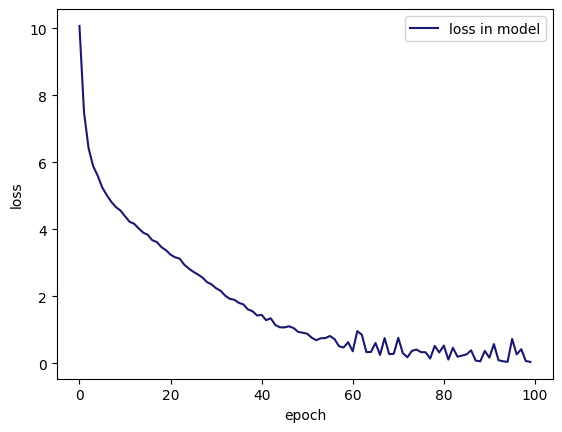

In [35]:
plt.plot(loss_list,label='loss in model',color='midnightblue')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

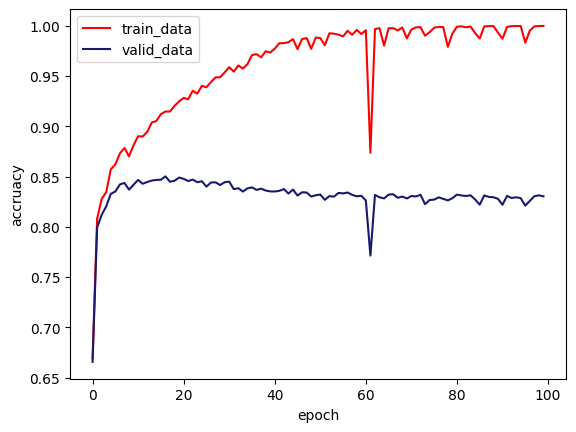

In [36]:
plt.plot(train_acc_list,label='train_data',color='red')
plt.plot(valid_acc_list,label='valid_data',color='midnightblue')
plt.xlabel('epoch')
plt.ylabel('accruacy')
plt.legend()
plt.show()

$\large \text{Hence we can see that our model is clearly overfitting in each variant so now we try regularization and other variants:}$

$\huge \text{Weight Initialization with normal 0,1}$

In [15]:
# Define the RNN model
class RNN(nn.Module):
    def __init__(self, hidden_size, output_size,n_layers,embedding_dim):
        super(RNN, self).__init__()
        self.apply(self._init_weights)
        self.hidden_size = hidden_size
        self.n_layers=n_layers
        self.rnn = nn.RNN(embedding_dim, hidden_size,n_layers,batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.relu=nn.ReLU()
        self.sigmoid=nn.Sigmoid()
        self.tanh=nn.Tanh()
        self.embed=nn.Embedding(len(vocab)+1,embedding_dim=embedding_dim)
    def forward(self, x):
        batch_size = x.size(0)
        # embeddings and lstm_out
        embeds = self.embed(x)
        # print(embed.shape)
        hidden=self.init_hidden(batch_size)

        # pass in the rnn layer
        out,hidden=self.rnn(embeds,hidden)
        # out=out.contiguous().view(-1,self.hidden_dim)
        # out=self.fc(out)



        output = self.sigmoid(self.fc(hidden.squeeze(0)))
        if self.n_layers==1:
            return output
        else:
            return output[-1]

    def init_hidden(self,batch_size):
        hidden=torch.zeros(self.n_layers,batch_size,self.hidden_size).to(device)
        return hidden
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=1.0)
            if module.bias is not None:
                module.bias.data.zero_()

In [38]:
hidden_size=100
output_size=1
n_layers=1
embedding_dim=64
model=RNN(hidden_size,output_size,n_layers,embedding_dim).to(device)
criterion =nn.BCELoss()
lr=0.0001
train_acc_list=[]
valid_acc_list=[]
loss_list=[]
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
epochs=100
num_epochs=tqdm(range(epochs))

# n_epochs=tqdm(range(epochs))
for epoch in num_epochs:

    running_loss = 0

    for i,(instances, labels) in enumerate(train_loader):

        optimizer.zero_grad()

        instances=instances.to(device)
        labels=labels.reshape(len(labels),-1).to(device).to(torch.float32)
        # print(instances.shape)
        output = model(instances)

        # print(labels.shape)
        # print(output.shape)
        # print(output)

        # print(output.shape)
        # print(labels.shape)
        loss = criterion(output, labels)


        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    loss_list.append(running_loss/batch_size)
    a=train_acc(model)
    train_acc_list.append(a)
    
    b=valid_acc(model)
    
    # print('accuracy over validation data set:',b)
    valid_acc_list.append(b)
    print('epoch is:',epoch+1,'accuracy over training/validation data set:',a,'/',b,' || running loss is:',running_loss/batch_size)
 


  1%|          | 1/100 [00:16<27:27, 16.64s/it]

epoch is: 1 accuracy over training/validation data set: 0.6884533333333334 / 0.68912  || running loss is: 9.820736492872237


  2%|▏         | 2/100 [00:33<26:59, 16.53s/it]

epoch is: 2 accuracy over training/validation data set: 0.7340266666666667 / 0.72968  || running loss is: 8.40735701560974


  3%|▎         | 3/100 [00:50<27:00, 16.71s/it]

epoch is: 3 accuracy over training/validation data set: 0.76416 / 0.75608  || running loss is: 7.818822673559189


  4%|▍         | 4/100 [01:10<29:24, 18.38s/it]

epoch is: 4 accuracy over training/validation data set: 0.7803466666666666 / 0.77168  || running loss is: 7.368846656680107


  5%|▌         | 5/100 [01:31<30:22, 19.18s/it]

epoch is: 5 accuracy over training/validation data set: 0.79704 / 0.79056  || running loss is: 6.9390224140882495


  6%|▌         | 6/100 [01:53<31:17, 19.97s/it]

epoch is: 6 accuracy over training/validation data set: 0.8097066666666667 / 0.79928  || running loss is: 6.567487864792347


  7%|▋         | 7/100 [02:14<31:52, 20.56s/it]

epoch is: 7 accuracy over training/validation data set: 0.8212 / 0.80728  || running loss is: 6.2442991176247595


  8%|▊         | 8/100 [02:35<31:26, 20.50s/it]

epoch is: 8 accuracy over training/validation data set: 0.8334666666666667 / 0.81928  || running loss is: 5.989584613144398


  9%|▉         | 9/100 [02:55<30:56, 20.40s/it]

epoch is: 9 accuracy over training/validation data set: 0.8348266666666667 / 0.82216  || running loss is: 5.791787004470825


 10%|█         | 10/100 [03:15<30:38, 20.43s/it]

epoch is: 10 accuracy over training/validation data set: 0.8489066666666667 / 0.82968  || running loss is: 5.627144358754158


 11%|█         | 11/100 [03:33<28:50, 19.44s/it]

epoch is: 11 accuracy over training/validation data set: 0.84968 / 0.83184  || running loss is: 5.464325394034386


 12%|█▏        | 12/100 [03:50<27:26, 18.71s/it]

epoch is: 12 accuracy over training/validation data set: 0.8556266666666666 / 0.83568  || running loss is: 5.31980765581131


 13%|█▎        | 13/100 [04:07<26:45, 18.45s/it]

epoch is: 13 accuracy over training/validation data set: 0.8565866666666667 / 0.83432  || running loss is: 5.205715077519417


 14%|█▍        | 14/100 [04:25<25:54, 18.08s/it]

epoch is: 14 accuracy over training/validation data set: 0.85816 / 0.83512  || running loss is: 5.096784709692002


 15%|█▌        | 15/100 [04:42<25:04, 17.70s/it]

epoch is: 15 accuracy over training/validation data set: 0.8589066666666667 / 0.83392  || running loss is: 5.013445341587067


 16%|█▌        | 16/100 [04:58<24:15, 17.33s/it]

epoch is: 16 accuracy over training/validation data set: 0.8664 / 0.84584  || running loss is: 4.919913404583931


 17%|█▋        | 17/100 [05:14<23:27, 16.96s/it]

epoch is: 17 accuracy over training/validation data set: 0.8568533333333334 / 0.83616  || running loss is: 4.845962291061878


 18%|█▊        | 18/100 [05:30<22:47, 16.68s/it]

epoch is: 18 accuracy over training/validation data set: 0.8729866666666667 / 0.84504  || running loss is: 4.790952251851559


 19%|█▉        | 19/100 [05:47<22:44, 16.85s/it]

epoch is: 19 accuracy over training/validation data set: 0.8767733333333333 / 0.84952  || running loss is: 4.7100686359405515


 20%|██        | 20/100 [06:06<23:06, 17.33s/it]

epoch is: 20 accuracy over training/validation data set: 0.87528 / 0.8488  || running loss is: 4.619497797042132


 21%|██        | 21/100 [06:21<22:00, 16.71s/it]

epoch is: 21 accuracy over training/validation data set: 0.8713333333333333 / 0.84424  || running loss is: 4.573229011595249


 22%|██▏       | 22/100 [06:37<21:15, 16.36s/it]

epoch is: 22 accuracy over training/validation data set: 0.8813866666666667 / 0.84832  || running loss is: 4.532556772083044


 23%|██▎       | 23/100 [06:52<20:37, 16.07s/it]

epoch is: 23 accuracy over training/validation data set: 0.8711466666666666 / 0.8396  || running loss is: 4.426993297487497


 24%|██▍       | 24/100 [07:11<21:23, 16.88s/it]

epoch is: 24 accuracy over training/validation data set: 0.88624 / 0.8512  || running loss is: 4.399276097416878


 25%|██▌       | 25/100 [07:25<20:03, 16.04s/it]

epoch is: 25 accuracy over training/validation data set: 0.8873333333333333 / 0.85016  || running loss is: 4.356388408094644


 26%|██▌       | 26/100 [07:39<19:08, 15.52s/it]

epoch is: 26 accuracy over training/validation data set: 0.88808 / 0.85016  || running loss is: 4.2601635658741


 27%|██▋       | 27/100 [07:56<19:15, 15.83s/it]

epoch is: 27 accuracy over training/validation data set: 0.88992 / 0.85064  || running loss is: 4.239754689186811


 28%|██▊       | 28/100 [08:10<18:21, 15.30s/it]

epoch is: 28 accuracy over training/validation data set: 0.8894133333333333 / 0.84792  || running loss is: 4.177097730636596


 29%|██▉       | 29/100 [08:28<19:16, 16.29s/it]

epoch is: 29 accuracy over training/validation data set: 0.8913066666666667 / 0.8508  || running loss is: 4.143286980837583


 30%|███       | 30/100 [08:45<19:12, 16.47s/it]

epoch is: 30 accuracy over training/validation data set: 0.89368 / 0.84736  || running loss is: 4.059037061184645


 31%|███       | 31/100 [09:01<18:44, 16.30s/it]

epoch is: 31 accuracy over training/validation data set: 0.8973866666666667 / 0.85144  || running loss is: 4.0434690608084205


 32%|███▏      | 32/100 [09:15<17:46, 15.69s/it]

epoch is: 32 accuracy over training/validation data set: 0.8976266666666667 / 0.84904  || running loss is: 3.985449144393206


 33%|███▎      | 33/100 [09:31<17:27, 15.63s/it]

epoch is: 33 accuracy over training/validation data set: 0.9012533333333334 / 0.85424  || running loss is: 3.923003833889961


 34%|███▍      | 34/100 [09:47<17:22, 15.80s/it]

epoch is: 34 accuracy over training/validation data set: 0.8848 / 0.83968  || running loss is: 3.8723244699835777


 35%|███▌      | 35/100 [10:02<16:56, 15.64s/it]

epoch is: 35 accuracy over training/validation data set: 0.90552 / 0.85216  || running loss is: 3.829344333857298


 36%|███▌      | 36/100 [10:17<16:11, 15.18s/it]

epoch is: 36 accuracy over training/validation data set: 0.9046133333333334 / 0.85056  || running loss is: 3.764442325681448


 37%|███▋      | 37/100 [10:31<15:49, 15.07s/it]

epoch is: 37 accuracy over training/validation data set: 0.9064 / 0.8528  || running loss is: 3.8041518957912923


 38%|███▊      | 38/100 [10:48<16:01, 15.50s/it]

epoch is: 38 accuracy over training/validation data set: 0.8972533333333333 / 0.84496  || running loss is: 3.662806267440319


 39%|███▉      | 39/100 [11:04<16:04, 15.82s/it]

epoch is: 39 accuracy over training/validation data set: 0.9059733333333333 / 0.84752  || running loss is: 3.6458109350502492


 40%|████      | 40/100 [11:21<15:54, 15.91s/it]

epoch is: 40 accuracy over training/validation data set: 0.9074933333333334 / 0.84808  || running loss is: 3.5934723576903345


 41%|████      | 41/100 [11:39<16:26, 16.71s/it]

epoch is: 41 accuracy over training/validation data set: 0.9112533333333334 / 0.84864  || running loss is: 3.5256830728054047


 42%|████▏     | 42/100 [11:58<16:45, 17.33s/it]

epoch is: 42 accuracy over training/validation data set: 0.9157333333333333 / 0.85072  || running loss is: 3.4845777615904807


 43%|████▎     | 43/100 [12:16<16:46, 17.65s/it]

epoch is: 43 accuracy over training/validation data set: 0.9171733333333333 / 0.85216  || running loss is: 3.4191126994788648


 44%|████▍     | 44/100 [12:35<16:54, 18.12s/it]

epoch is: 44 accuracy over training/validation data set: 0.91344 / 0.84856  || running loss is: 3.351665318980813


 45%|████▌     | 45/100 [12:55<17:04, 18.62s/it]

epoch is: 45 accuracy over training/validation data set: 0.9198933333333333 / 0.84592  || running loss is: 3.347314484715462


 46%|████▌     | 46/100 [13:14<16:53, 18.77s/it]

epoch is: 46 accuracy over training/validation data set: 0.9151466666666667 / 0.844  || running loss is: 3.2984372897446157


 47%|████▋     | 47/100 [13:34<16:42, 18.91s/it]

epoch is: 47 accuracy over training/validation data set: 0.92448 / 0.84752  || running loss is: 3.2536695527285335


 48%|████▊     | 48/100 [13:52<16:07, 18.61s/it]

epoch is: 48 accuracy over training/validation data set: 0.9204266666666666 / 0.846  || running loss is: 3.1722893378138544


 49%|████▉     | 49/100 [14:09<15:36, 18.36s/it]

epoch is: 49 accuracy over training/validation data set: 0.9201866666666667 / 0.84464  || running loss is: 3.1074812500178814


 50%|█████     | 50/100 [14:27<15:05, 18.11s/it]

epoch is: 50 accuracy over training/validation data set: 0.92272 / 0.84472  || running loss is: 3.07280865162611


 51%|█████     | 51/100 [14:47<15:18, 18.75s/it]

epoch is: 51 accuracy over training/validation data set: 0.9252533333333334 / 0.8436  || running loss is: 3.0381148698925973


 52%|█████▏    | 52/100 [15:07<15:21, 19.21s/it]

epoch is: 52 accuracy over training/validation data set: 0.92288 / 0.84184  || running loss is: 3.000710171610117


 53%|█████▎    | 53/100 [15:28<15:16, 19.50s/it]

epoch is: 53 accuracy over training/validation data set: 0.9328533333333333 / 0.846  || running loss is: 2.927133712768555


 54%|█████▍    | 54/100 [15:48<15:09, 19.78s/it]

epoch is: 54 accuracy over training/validation data set: 0.9285333333333333 / 0.8396  || running loss is: 2.848287508264184


 55%|█████▌    | 55/100 [16:08<14:51, 19.81s/it]

epoch is: 55 accuracy over training/validation data set: 0.9377866666666667 / 0.84192  || running loss is: 2.7990135588496923


 56%|█████▌    | 56/100 [16:28<14:33, 19.85s/it]

epoch is: 56 accuracy over training/validation data set: 0.9342133333333333 / 0.84376  || running loss is: 2.784156304374337


 57%|█████▋    | 57/100 [16:48<14:19, 20.00s/it]

epoch is: 57 accuracy over training/validation data set: 0.9401866666666666 / 0.8428  || running loss is: 2.704245786443353


 58%|█████▊    | 58/100 [17:09<14:10, 20.26s/it]

epoch is: 58 accuracy over training/validation data set: 0.9418133333333333 / 0.84048  || running loss is: 2.6582875975966456


 59%|█████▉    | 59/100 [17:29<13:41, 20.05s/it]

epoch is: 59 accuracy over training/validation data set: 0.9410666666666667 / 0.84072  || running loss is: 2.5952143570780755


 60%|██████    | 60/100 [17:48<13:13, 19.84s/it]

epoch is: 60 accuracy over training/validation data set: 0.9370133333333334 / 0.8368  || running loss is: 2.576757870838046


 61%|██████    | 61/100 [18:05<12:20, 19.00s/it]

epoch is: 61 accuracy over training/validation data set: 0.94384 / 0.83648  || running loss is: 2.491496399343014


 62%|██████▏   | 62/100 [18:23<11:51, 18.71s/it]

epoch is: 62 accuracy over training/validation data set: 0.9478933333333334 / 0.84008  || running loss is: 2.423158386349678


 63%|██████▎   | 63/100 [18:41<11:25, 18.53s/it]

epoch is: 63 accuracy over training/validation data set: 0.94736 / 0.83808  || running loss is: 2.3926535922288896


 64%|██████▍   | 64/100 [18:59<11:01, 18.38s/it]

epoch is: 64 accuracy over training/validation data set: 0.94712 / 0.83752  || running loss is: 2.328243474327028


 65%|██████▌   | 65/100 [19:18<10:46, 18.46s/it]

epoch is: 65 accuracy over training/validation data set: 0.9450933333333333 / 0.83944  || running loss is: 2.2996945683285595


 66%|██████▌   | 66/100 [19:32<09:41, 17.12s/it]

epoch is: 66 accuracy over training/validation data set: 0.9407733333333334 / 0.83352  || running loss is: 2.177574713602662


 67%|██████▋   | 67/100 [19:49<09:21, 17.03s/it]

epoch is: 67 accuracy over training/validation data set: 0.954 / 0.83632  || running loss is: 2.1796682293340566


 68%|██████▊   | 68/100 [20:03<08:42, 16.33s/it]

epoch is: 68 accuracy over training/validation data set: 0.95672 / 0.83672  || running loss is: 2.1589574889466165


 69%|██████▉   | 69/100 [20:22<08:46, 17.00s/it]

epoch is: 69 accuracy over training/validation data set: 0.9512533333333333 / 0.8348  || running loss is: 2.1102231146395205


 70%|███████   | 70/100 [20:40<08:37, 17.24s/it]

epoch is: 70 accuracy over training/validation data set: 0.9466133333333333 / 0.83248  || running loss is: 2.042807772085071


 71%|███████   | 71/100 [20:57<08:22, 17.33s/it]

epoch is: 71 accuracy over training/validation data set: 0.9604 / 0.83592  || running loss is: 1.9866589054837822


 72%|███████▏  | 72/100 [21:15<08:06, 17.37s/it]

epoch is: 72 accuracy over training/validation data set: 0.9639733333333333 / 0.83624  || running loss is: 1.9266596771404148


 73%|███████▎  | 73/100 [21:32<07:49, 17.38s/it]

epoch is: 73 accuracy over training/validation data set: 0.9637066666666667 / 0.83336  || running loss is: 1.8758939565718173


 74%|███████▍  | 74/100 [21:49<07:30, 17.33s/it]

epoch is: 74 accuracy over training/validation data set: 0.96088 / 0.83392  || running loss is: 1.8581787602230906


 75%|███████▌  | 75/100 [22:06<07:10, 17.24s/it]

epoch is: 75 accuracy over training/validation data set: 0.96744 / 0.83624  || running loss is: 1.8690457188151777


 76%|███████▌  | 76/100 [22:23<06:53, 17.21s/it]

epoch is: 76 accuracy over training/validation data set: 0.9708266666666666 / 0.83544  || running loss is: 1.7761038756929337


 77%|███████▋  | 77/100 [22:44<06:57, 18.15s/it]

epoch is: 77 accuracy over training/validation data set: 0.9690933333333334 / 0.83216  || running loss is: 1.664968114513904


 78%|███████▊  | 78/100 [23:02<06:41, 18.25s/it]

epoch is: 78 accuracy over training/validation data set: 0.9703733333333333 / 0.82848  || running loss is: 1.642216526288539


 79%|███████▉  | 79/100 [23:21<06:26, 18.38s/it]

epoch is: 79 accuracy over training/validation data set: 0.9686933333333333 / 0.82992  || running loss is: 1.5807494732737541


 80%|████████  | 80/100 [23:40<06:10, 18.53s/it]

epoch is: 80 accuracy over training/validation data set: 0.9741066666666667 / 0.83128  || running loss is: 1.53731111433357


 81%|████████  | 81/100 [23:59<05:54, 18.66s/it]

epoch is: 81 accuracy over training/validation data set: 0.96216 / 0.8276  || running loss is: 1.5346109056286514


 82%|████████▏ | 82/100 [24:15<05:24, 18.02s/it]

epoch is: 82 accuracy over training/validation data set: 0.97416 / 0.83368  || running loss is: 1.4954363757930695


 83%|████████▎ | 83/100 [24:33<05:06, 18.06s/it]

epoch is: 83 accuracy over training/validation data set: 0.9733066666666667 / 0.82936  || running loss is: 1.5795583616942168


 84%|████████▍ | 84/100 [24:49<04:36, 17.31s/it]

epoch is: 84 accuracy over training/validation data set: 0.95712 / 0.82832  || running loss is: 1.3916574198193847


 85%|████████▌ | 85/100 [25:03<04:06, 16.41s/it]

epoch is: 85 accuracy over training/validation data set: 0.9799733333333334 / 0.83168  || running loss is: 1.3475552172213794


 86%|████████▌ | 86/100 [25:20<03:53, 16.65s/it]

epoch is: 86 accuracy over training/validation data set: 0.95304 / 0.82576  || running loss is: 1.3589539968594908


 87%|████████▋ | 87/100 [25:35<03:28, 16.05s/it]

epoch is: 87 accuracy over training/validation data set: 0.97544 / 0.82624  || running loss is: 1.2577451474033297


 88%|████████▊ | 88/100 [25:50<03:07, 15.61s/it]

epoch is: 88 accuracy over training/validation data set: 0.9801333333333333 / 0.82912  || running loss is: 1.2847298444993793


 89%|████████▉ | 89/100 [26:04<02:48, 15.35s/it]

epoch is: 89 accuracy over training/validation data set: 0.9786133333333333 / 0.82792  || running loss is: 1.1860462952312083


 90%|█████████ | 90/100 [26:19<02:29, 14.97s/it]

epoch is: 90 accuracy over training/validation data set: 0.9759733333333334 / 0.82712  || running loss is: 1.7014785517007112


 91%|█████████ | 91/100 [26:33<02:12, 14.75s/it]

epoch is: 91 accuracy over training/validation data set: 0.9863733333333333 / 0.82824  || running loss is: 1.0708750655595214


 92%|█████████▏| 92/100 [26:52<02:09, 16.13s/it]

epoch is: 92 accuracy over training/validation data set: 0.9736533333333334 / 0.82952  || running loss is: 1.076446703625843


 93%|█████████▎| 93/100 [27:09<01:55, 16.44s/it]

epoch is: 93 accuracy over training/validation data set: 0.986 / 0.82856  || running loss is: 1.0369455930264666


 94%|█████████▍| 94/100 [27:26<01:38, 16.39s/it]

epoch is: 94 accuracy over training/validation data set: 0.97968 / 0.82128  || running loss is: 1.0377202877867966


 95%|█████████▌| 95/100 [27:43<01:22, 16.55s/it]

epoch is: 95 accuracy over training/validation data set: 0.9881333333333333 / 0.82744  || running loss is: 0.9813189513422549


 96%|█████████▌| 96/100 [27:58<01:05, 16.29s/it]

epoch is: 96 accuracy over training/validation data set: 0.9893333333333333 / 0.82496  || running loss is: 0.8868524331133812


 97%|█████████▋| 97/100 [28:13<00:47, 15.89s/it]

epoch is: 97 accuracy over training/validation data set: 0.9638133333333333 / 0.82232  || running loss is: 1.040392775852233


 98%|█████████▊| 98/100 [28:27<00:30, 15.39s/it]

epoch is: 98 accuracy over training/validation data set: 0.9833866666666666 / 0.82432  || running loss is: 0.8876134318253025


 99%|█████████▉| 99/100 [28:42<00:15, 15.20s/it]

epoch is: 99 accuracy over training/validation data set: 0.9902666666666666 / 0.82344  || running loss is: 0.9316248542931862


100%|██████████| 100/100 [29:00<00:00, 17.41s/it]

epoch is: 100 accuracy over training/validation data set: 0.9919733333333334 / 0.82536  || running loss is: 0.8280873588519171


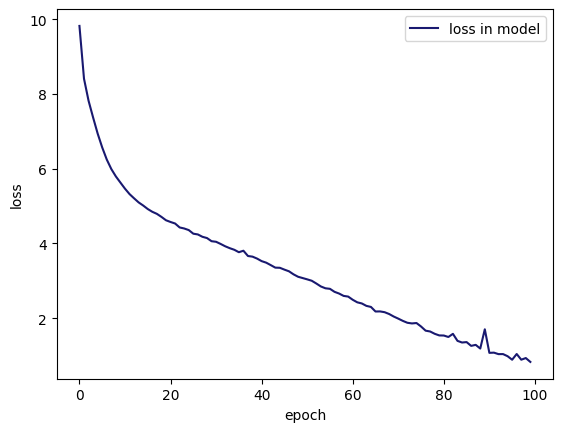

In [39]:
plt.plot(loss_list,label='loss in model',color='midnightblue')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

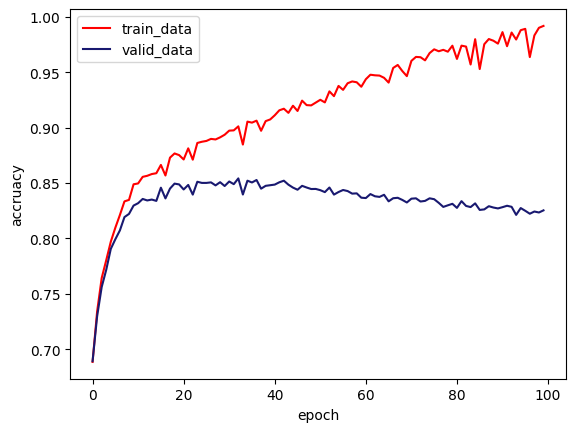

In [40]:
plt.plot(train_acc_list,label='train_data',color='red')
plt.plot(valid_acc_list,label='valid_data',color='midnightblue')
plt.xlabel('epoch')
plt.ylabel('accruacy')
plt.legend()
plt.show()

In [16]:
# Define the RNN model
class RNN(nn.Module):
    def __init__(self, hidden_size, output_size,n_layers,embedding_dim):
        super(RNN, self).__init__()
        self.apply(self._init_weights)
        self.hidden_size = hidden_size
        self.n_layers=n_layers
        self.rnn = nn.RNN(embedding_dim, hidden_size,n_layers,batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.relu=nn.ReLU()
        self.sigmoid=nn.Sigmoid()
        self.tanh=nn.Tanh()
        self.embed=nn.Embedding(len(vocab)+1,embedding_dim=embedding_dim)
    def forward(self, x):
        batch_size = x.size(0)
        # embeddings and lstm_out
        embeds = self.embed(x)
        # print(embed.shape)
        hidden=self.init_hidden(batch_size)

        # pass in the rnn layer
        out,hidden=self.rnn(embeds,hidden)
        # out=out.contiguous().view(-1,self.hidden_dim)
        # out=self.fc(out)



        output = self.sigmoid(self.fc(hidden.squeeze(0)))
        if self.n_layers==1:
            return output
        else:
            return output[-1]

    def init_hidden(self,batch_size):
        hidden=torch.zeros(self.n_layers,batch_size,self.hidden_size).to(device)
        return hidden
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=1.0/np.sqrt(37500))
            if module.bias is not None:
                module.bias.data.zero_()

In [42]:
hidden_size=100
output_size=1
n_layers=1
embedding_dim=64
model=RNN(hidden_size,output_size,n_layers,embedding_dim).to(device)
criterion =nn.BCELoss()
lr=0.0001
train_acc_list=[]
valid_acc_list=[]
loss_list=[]
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
epochs=100
num_epochs=tqdm(range(epochs))

# n_epochs=tqdm(range(epochs))
for epoch in num_epochs:

    running_loss = 0

    for i,(instances, labels) in enumerate(train_loader):

        optimizer.zero_grad()

        instances=instances.to(device)
        labels=labels.reshape(len(labels),-1).to(device).to(torch.float32)
        # print(instances.shape)
        output = model(instances)

        # print(labels.shape)
        # print(output.shape)
        # print(output)

        # print(output.shape)
        # print(labels.shape)
        loss = criterion(output, labels)


        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    loss_list.append(running_loss/batch_size)
    a=train_acc(model)
    train_acc_list.append(a)
    
    b=valid_acc(model)
    
    # print('accuracy over validation data set:',b)
    valid_acc_list.append(b)
    print('epoch is:',epoch+1,'accuracy over training/validation data set:',a,'/',b,' || running loss is:',running_loss/batch_size)
 


  1%|          | 1/100 [00:19<31:44, 19.24s/it]

epoch is: 1 accuracy over training/validation data set: 0.6605333333333333 / 0.66504  || running loss is: 10.180488660931587


  2%|▏         | 2/100 [00:38<31:29, 19.28s/it]

epoch is: 2 accuracy over training/validation data set: 0.7309866666666667 / 0.72504  || running loss is: 8.73573259115219


  3%|▎         | 3/100 [00:58<31:19, 19.37s/it]

epoch is: 3 accuracy over training/validation data set: 0.7471466666666666 / 0.74232  || running loss is: 7.927512226700783


  4%|▍         | 4/100 [01:18<31:31, 19.70s/it]

epoch is: 4 accuracy over training/validation data set: 0.7806133333333334 / 0.77368  || running loss is: 7.3798365265131


  5%|▌         | 5/100 [01:34<29:04, 18.37s/it]

epoch is: 5 accuracy over training/validation data set: 0.7974133333333333 / 0.79064  || running loss is: 6.920437769889832


  6%|▌         | 6/100 [01:49<27:09, 17.34s/it]

epoch is: 6 accuracy over training/validation data set: 0.8014666666666667 / 0.79312  || running loss is: 6.553271193802357


  7%|▋         | 7/100 [02:05<25:59, 16.77s/it]

epoch is: 7 accuracy over training/validation data set: 0.8230666666666666 / 0.81128  || running loss is: 6.275690143406391


  8%|▊         | 8/100 [02:19<24:29, 15.98s/it]

epoch is: 8 accuracy over training/validation data set: 0.8315733333333334 / 0.81976  || running loss is: 6.006608535349369


  9%|▉         | 9/100 [02:33<23:25, 15.45s/it]

epoch is: 9 accuracy over training/validation data set: 0.8371466666666667 / 0.8232  || running loss is: 5.807737910151482


 10%|█         | 10/100 [02:48<22:50, 15.23s/it]

epoch is: 10 accuracy over training/validation data set: 0.8438666666666667 / 0.82928  || running loss is: 5.655100359320641


 11%|█         | 11/100 [03:04<22:50, 15.40s/it]

epoch is: 11 accuracy over training/validation data set: 0.84792 / 0.83104  || running loss is: 5.482467441260814


 12%|█▏        | 12/100 [03:23<24:09, 16.47s/it]

epoch is: 12 accuracy over training/validation data set: 0.8470933333333334 / 0.82848  || running loss is: 5.3612599107623105


 13%|█▎        | 13/100 [03:39<23:39, 16.32s/it]

epoch is: 13 accuracy over training/validation data set: 0.8564266666666667 / 0.836  || running loss is: 5.2393620723485945


 14%|█▍        | 14/100 [03:56<23:56, 16.70s/it]

epoch is: 14 accuracy over training/validation data set: 0.8613866666666666 / 0.83872  || running loss is: 5.12980152964592


 15%|█▌        | 15/100 [04:13<23:48, 16.81s/it]

epoch is: 15 accuracy over training/validation data set: 0.85864 / 0.83912  || running loss is: 5.015712361037731


 16%|█▌        | 16/100 [04:31<23:51, 17.04s/it]

epoch is: 16 accuracy over training/validation data set: 0.8625333333333334 / 0.83832  || running loss is: 4.950403619110585


 17%|█▋        | 17/100 [04:47<23:13, 16.79s/it]

epoch is: 17 accuracy over training/validation data set: 0.8616266666666667 / 0.836  || running loss is: 4.864046658277512


 18%|█▊        | 18/100 [05:03<22:36, 16.55s/it]

epoch is: 18 accuracy over training/validation data set: 0.87456 / 0.84712  || running loss is: 4.808075765520334


 19%|█▉        | 19/100 [05:20<22:22, 16.58s/it]

epoch is: 19 accuracy over training/validation data set: 0.8745866666666666 / 0.84912  || running loss is: 4.719799733310938


 20%|██        | 20/100 [05:37<22:34, 16.93s/it]

epoch is: 20 accuracy over training/validation data set: 0.87544 / 0.8448  || running loss is: 4.632027802318334


 21%|██        | 21/100 [05:54<22:17, 16.93s/it]

epoch is: 21 accuracy over training/validation data set: 0.8749866666666667 / 0.84608  || running loss is: 4.619521300494671


 22%|██▏       | 22/100 [06:13<22:38, 17.41s/it]

epoch is: 22 accuracy over training/validation data set: 0.8757333333333334 / 0.8464  || running loss is: 4.541680601984263


 23%|██▎       | 23/100 [06:33<23:23, 18.23s/it]

epoch is: 23 accuracy over training/validation data set: 0.88152 / 0.84744  || running loss is: 4.49879373639822


 24%|██▍       | 24/100 [06:54<24:12, 19.11s/it]

epoch is: 24 accuracy over training/validation data set: 0.8834933333333334 / 0.84952  || running loss is: 4.415585140138864


 25%|██▌       | 25/100 [07:15<24:26, 19.55s/it]

epoch is: 25 accuracy over training/validation data set: 0.88424 / 0.84872  || running loss is: 4.357727631032467


 26%|██▌       | 26/100 [07:35<24:13, 19.64s/it]

epoch is: 26 accuracy over training/validation data set: 0.8882933333333334 / 0.85008  || running loss is: 4.333719393014908


 27%|██▋       | 27/100 [07:56<24:22, 20.03s/it]

epoch is: 27 accuracy over training/validation data set: 0.87832 / 0.84152  || running loss is: 4.2421814557909965


 28%|██▊       | 28/100 [08:16<24:07, 20.10s/it]

epoch is: 28 accuracy over training/validation data set: 0.8904 / 0.85048  || running loss is: 4.223311437666416


 29%|██▉       | 29/100 [08:36<23:53, 20.19s/it]

epoch is: 29 accuracy over training/validation data set: 0.89336 / 0.8524  || running loss is: 4.164069712907076


 30%|███       | 30/100 [08:57<23:35, 20.23s/it]

epoch is: 30 accuracy over training/validation data set: 0.88928 / 0.84712  || running loss is: 4.100804887190461


 31%|███       | 31/100 [09:17<23:16, 20.24s/it]

epoch is: 31 accuracy over training/validation data set: 0.8924 / 0.84824  || running loss is: 4.085149928927422


 32%|███▏      | 32/100 [09:38<23:16, 20.54s/it]

epoch is: 32 accuracy over training/validation data set: 0.8912266666666666 / 0.8468  || running loss is: 4.006337590217591


 33%|███▎      | 33/100 [09:54<21:19, 19.10s/it]

epoch is: 33 accuracy over training/validation data set: 0.8968 / 0.84976  || running loss is: 3.981888422071934


 34%|███▍      | 34/100 [10:12<20:35, 18.72s/it]

epoch is: 34 accuracy over training/validation data set: 0.8910133333333333 / 0.84816  || running loss is: 3.961788633167744


 35%|███▌      | 35/100 [10:30<20:06, 18.57s/it]

epoch is: 35 accuracy over training/validation data set: 0.8994933333333334 / 0.84512  || running loss is: 3.912129256874323


 36%|███▌      | 36/100 [10:49<19:53, 18.64s/it]

epoch is: 36 accuracy over training/validation data set: 0.9029866666666667 / 0.85184  || running loss is: 3.8506472720205784


 37%|███▋      | 37/100 [11:08<19:40, 18.73s/it]

epoch is: 37 accuracy over training/validation data set: 0.90528 / 0.848  || running loss is: 3.7936282022297383


 38%|███▊      | 38/100 [11:27<19:39, 19.02s/it]

epoch is: 38 accuracy over training/validation data set: 0.9053066666666667 / 0.84632  || running loss is: 3.7334741981327535


 39%|███▉      | 39/100 [11:47<19:26, 19.12s/it]

epoch is: 39 accuracy over training/validation data set: 0.90544 / 0.84656  || running loss is: 3.732807531952858


 40%|████      | 40/100 [12:05<19:01, 19.03s/it]

epoch is: 40 accuracy over training/validation data set: 0.90736 / 0.84512  || running loss is: 3.6583070500195025


 41%|████      | 41/100 [12:24<18:32, 18.85s/it]

epoch is: 41 accuracy over training/validation data set: 0.9097066666666667 / 0.848  || running loss is: 3.605867642611265


 42%|████▏     | 42/100 [12:43<18:11, 18.82s/it]

epoch is: 42 accuracy over training/validation data set: 0.9120533333333334 / 0.84872  || running loss is: 3.5346129624545575


 43%|████▎     | 43/100 [13:01<17:40, 18.60s/it]

epoch is: 43 accuracy over training/validation data set: 0.9143466666666666 / 0.8468  || running loss is: 3.54504286468029


 44%|████▍     | 44/100 [13:19<17:16, 18.51s/it]

epoch is: 44 accuracy over training/validation data set: 0.9149866666666666 / 0.84616  || running loss is: 3.4646019177138805


 45%|████▌     | 45/100 [13:34<15:55, 17.37s/it]

epoch is: 45 accuracy over training/validation data set: 0.91232 / 0.84576  || running loss is: 3.4254992431402207


 46%|████▌     | 46/100 [13:49<15:09, 16.84s/it]

epoch is: 46 accuracy over training/validation data set: 0.9072533333333334 / 0.84328  || running loss is: 3.4156382026523353


 47%|████▋     | 47/100 [14:08<15:15, 17.28s/it]

epoch is: 47 accuracy over training/validation data set: 0.9180266666666667 / 0.84488  || running loss is: 3.3358044828474522


 48%|████▊     | 48/100 [14:26<15:08, 17.48s/it]

epoch is: 48 accuracy over training/validation data set: 0.9090133333333333 / 0.84208  || running loss is: 3.29313726849854


 49%|████▉     | 49/100 [14:42<14:33, 17.12s/it]

epoch is: 49 accuracy over training/validation data set: 0.9241866666666667 / 0.84376  || running loss is: 3.201862126067281


 50%|█████     | 50/100 [15:00<14:36, 17.53s/it]

epoch is: 50 accuracy over training/validation data set: 0.9231466666666667 / 0.84336  || running loss is: 3.1593161514401435


 51%|█████     | 51/100 [15:13<13:04, 16.01s/it]

epoch is: 51 accuracy over training/validation data set: 0.9266666666666666 / 0.84592  || running loss is: 3.128581195920706


 52%|█████▏    | 52/100 [15:30<13:03, 16.33s/it]

epoch is: 52 accuracy over training/validation data set: 0.9214933333333334 / 0.84216  || running loss is: 3.0447500171512365


 53%|█████▎    | 53/100 [15:47<12:56, 16.52s/it]

epoch is: 53 accuracy over training/validation data set: 0.9248266666666667 / 0.8404  || running loss is: 3.0101887185871603


 54%|█████▍    | 54/100 [16:04<12:46, 16.66s/it]

epoch is: 54 accuracy over training/validation data set: 0.92032 / 0.838  || running loss is: 2.982428148686886


 55%|█████▌    | 55/100 [16:20<12:28, 16.64s/it]

epoch is: 55 accuracy over training/validation data set: 0.9224533333333333 / 0.83912  || running loss is: 2.913474203571677


 56%|█████▌    | 56/100 [16:37<12:10, 16.61s/it]

epoch is: 56 accuracy over training/validation data set: 0.9355466666666666 / 0.8432  || running loss is: 2.8556107597053053


 57%|█████▋    | 57/100 [16:53<11:49, 16.49s/it]

epoch is: 57 accuracy over training/validation data set: 0.93328 / 0.83816  || running loss is: 2.8038745179772375


 58%|█████▊    | 58/100 [17:12<11:57, 17.07s/it]

epoch is: 58 accuracy over training/validation data set: 0.93688 / 0.83912  || running loss is: 2.7281858383119104


 59%|█████▉    | 59/100 [17:24<10:37, 15.54s/it]

epoch is: 59 accuracy over training/validation data set: 0.9033866666666667 / 0.82416  || running loss is: 2.7349305123090746


 60%|██████    | 60/100 [17:38<10:05, 15.14s/it]

epoch is: 60 accuracy over training/validation data set: 0.9352266666666667 / 0.83888  || running loss is: 2.6660120549052952


 61%|██████    | 61/100 [17:51<09:31, 14.65s/it]

epoch is: 61 accuracy over training/validation data set: 0.9320533333333333 / 0.83752  || running loss is: 2.5972647962719204


 62%|██████▏   | 62/100 [18:09<09:52, 15.60s/it]

epoch is: 62 accuracy over training/validation data set: 0.93968 / 0.8396  || running loss is: 2.5298518838733433


 63%|██████▎   | 63/100 [18:28<10:13, 16.59s/it]

epoch is: 63 accuracy over training/validation data set: 0.9425333333333333 / 0.83632  || running loss is: 2.482034257724881


 64%|██████▍   | 64/100 [18:44<09:50, 16.40s/it]

epoch is: 64 accuracy over training/validation data set: 0.94168 / 0.83736  || running loss is: 2.477084109149873


 65%|██████▌   | 65/100 [18:59<09:23, 16.10s/it]

epoch is: 65 accuracy over training/validation data set: 0.9445333333333333 / 0.83568  || running loss is: 2.4240115429088473


 66%|██████▌   | 66/100 [19:15<09:01, 15.93s/it]

epoch is: 66 accuracy over training/validation data set: 0.9414666666666667 / 0.83288  || running loss is: 2.3364611322805287


 67%|██████▋   | 67/100 [19:30<08:41, 15.79s/it]

epoch is: 67 accuracy over training/validation data set: 0.9457866666666667 / 0.8348  || running loss is: 2.2884160327911376


 68%|██████▊   | 68/100 [19:45<08:18, 15.58s/it]

epoch is: 68 accuracy over training/validation data set: 0.9487733333333334 / 0.83672  || running loss is: 2.238692624792457


 69%|██████▉   | 69/100 [20:01<07:59, 15.46s/it]

epoch is: 69 accuracy over training/validation data set: 0.9498933333333334 / 0.83432  || running loss is: 2.1929763812199234


 70%|███████   | 70/100 [20:15<07:36, 15.23s/it]

epoch is: 70 accuracy over training/validation data set: 0.9515733333333334 / 0.83288  || running loss is: 2.1301635250449182


 71%|███████   | 71/100 [20:30<07:18, 15.11s/it]

epoch is: 71 accuracy over training/validation data set: 0.95112 / 0.83384  || running loss is: 2.119087287038565


 72%|███████▏  | 72/100 [20:45<07:02, 15.07s/it]

epoch is: 72 accuracy over training/validation data set: 0.9580533333333333 / 0.83376  || running loss is: 2.044921903759241


 73%|███████▎  | 73/100 [21:04<07:17, 16.21s/it]

epoch is: 73 accuracy over training/validation data set: 0.94864 / 0.83216  || running loss is: 2.0284742469340564


 74%|███████▍  | 74/100 [21:20<06:57, 16.04s/it]

epoch is: 74 accuracy over training/validation data set: 0.95952 / 0.8328  || running loss is: 1.94937873698771


 75%|███████▌  | 75/100 [21:36<06:39, 15.99s/it]

epoch is: 75 accuracy over training/validation data set: 0.9582133333333334 / 0.832  || running loss is: 1.9634646505117417


 76%|███████▌  | 76/100 [21:51<06:21, 15.88s/it]

epoch is: 76 accuracy over training/validation data set: 0.96504 / 0.83424  || running loss is: 1.8995130563899876


 77%|███████▋  | 77/100 [22:05<05:47, 15.13s/it]

epoch is: 77 accuracy over training/validation data set: 0.9672533333333333 / 0.83448  || running loss is: 1.7972850169986487


 78%|███████▊  | 78/100 [22:19<05:31, 15.07s/it]

epoch is: 78 accuracy over training/validation data set: 0.95808 / 0.82888  || running loss is: 1.7540545038878919


 79%|███████▉  | 79/100 [22:34<05:09, 14.76s/it]

epoch is: 79 accuracy over training/validation data set: 0.96928 / 0.8328  || running loss is: 1.7689441131241619


 80%|████████  | 80/100 [22:48<04:51, 14.59s/it]

epoch is: 80 accuracy over training/validation data set: 0.9369333333333333 / 0.82904  || running loss is: 1.75105324216187


 81%|████████  | 81/100 [23:02<04:37, 14.60s/it]

epoch is: 81 accuracy over training/validation data set: 0.9671466666666667 / 0.82912  || running loss is: 1.646603657566011


 82%|████████▏ | 82/100 [23:17<04:20, 14.48s/it]

epoch is: 82 accuracy over training/validation data set: 0.9688 / 0.82576  || running loss is: 1.6147614652849733


 83%|████████▎ | 83/100 [23:30<03:58, 14.05s/it]

epoch is: 83 accuracy over training/validation data set: 0.9712533333333333 / 0.83032  || running loss is: 1.5997634037025272


 84%|████████▍ | 84/100 [23:43<03:43, 13.99s/it]

epoch is: 84 accuracy over training/validation data set: 0.9748 / 0.82976  || running loss is: 1.6601069575920702


 85%|████████▌ | 85/100 [23:58<03:30, 14.06s/it]

epoch is: 85 accuracy over training/validation data set: 0.97368 / 0.828  || running loss is: 1.4637887845467776


 86%|████████▌ | 86/100 [24:12<03:19, 14.25s/it]

epoch is: 86 accuracy over training/validation data set: 0.9754666666666667 / 0.82928  || running loss is: 1.4414818404614926


 87%|████████▋ | 87/100 [24:27<03:08, 14.48s/it]

epoch is: 87 accuracy over training/validation data set: 0.9795733333333333 / 0.8304  || running loss is: 1.4294895347021521


 88%|████████▊ | 88/100 [24:42<02:55, 14.61s/it]

epoch is: 88 accuracy over training/validation data set: 0.97576 / 0.8248  || running loss is: 1.4014891989529132


 89%|████████▉ | 89/100 [25:00<02:51, 15.58s/it]

epoch is: 89 accuracy over training/validation data set: 0.9774133333333334 / 0.8284  || running loss is: 1.306529968418181


 90%|█████████ | 90/100 [25:15<02:34, 15.48s/it]

epoch is: 90 accuracy over training/validation data set: 0.9810133333333333 / 0.8288  || running loss is: 1.296477587223053


 91%|█████████ | 91/100 [25:31<02:18, 15.40s/it]

epoch is: 91 accuracy over training/validation data set: 0.9788 / 0.82688  || running loss is: 1.2326432767417281


 92%|█████████▏| 92/100 [25:46<02:02, 15.30s/it]

epoch is: 92 accuracy over training/validation data set: 0.9764 / 0.82464  || running loss is: 1.2266430038027465


 93%|█████████▎| 93/100 [25:58<01:40, 14.33s/it]

epoch is: 93 accuracy over training/validation data set: 0.9786666666666667 / 0.82208  || running loss is: 1.1732736644893884


 94%|█████████▍| 94/100 [26:14<01:29, 14.98s/it]

epoch is: 94 accuracy over training/validation data set: 0.98368 / 0.82624  || running loss is: 1.1385316533967853


 95%|█████████▌| 95/100 [26:31<01:17, 15.52s/it]

epoch is: 95 accuracy over training/validation data set: 0.9848 / 0.82592  || running loss is: 1.1275379223749042


 96%|█████████▌| 96/100 [26:49<01:04, 16.12s/it]

epoch is: 96 accuracy over training/validation data set: 0.9682666666666667 / 0.82232  || running loss is: 1.0170308187138288


 97%|█████████▋| 97/100 [27:03<00:46, 15.66s/it]

epoch is: 97 accuracy over training/validation data set: 0.9833866666666666 / 0.82272  || running loss is: 1.0976194429397583


 98%|█████████▊| 98/100 [27:17<00:30, 15.27s/it]

epoch is: 98 accuracy over training/validation data set: 0.9721066666666667 / 0.8208  || running loss is: 1.1694602844770998


 99%|█████████▉| 99/100 [27:32<00:14, 14.92s/it]

epoch is: 99 accuracy over training/validation data set: 0.9767733333333334 / 0.82392  || running loss is: 0.9789030946791172


100%|██████████| 100/100 [27:46<00:00, 16.66s/it]

epoch is: 100 accuracy over training/validation data set: 0.98936 / 0.8268  || running loss is: 1.1173504643421621


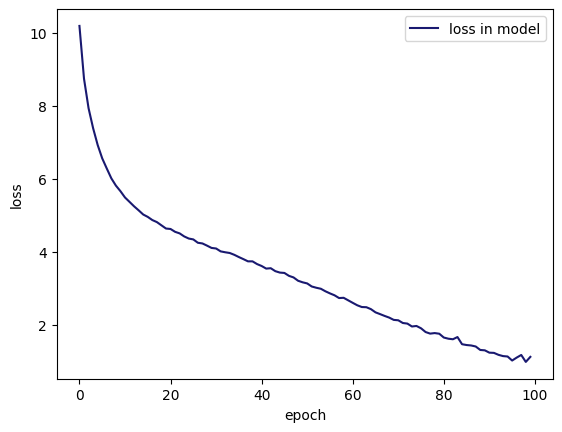

In [43]:
plt.plot(loss_list,label='loss in model',color='midnightblue')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

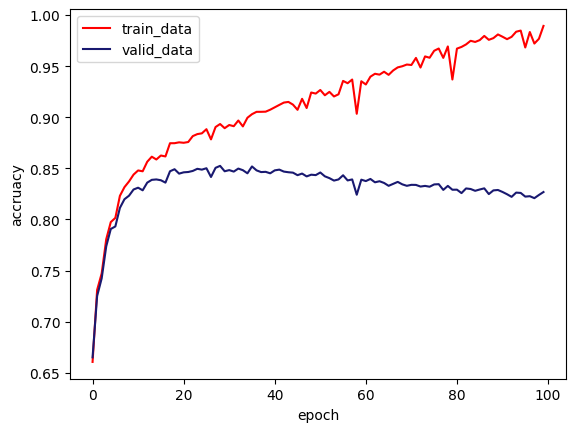

In [44]:
plt.plot(train_acc_list,label='train_data',color='red')
plt.plot(valid_acc_list,label='valid_data',color='midnightblue')
plt.xlabel('epoch')
plt.ylabel('accruacy')
plt.legend()
plt.show()

$\large \text{We obsereved that weight initilization does not work properly for overfitting.}$

$\huge \text{L2 Regularization:}$

In [45]:
hidden_size=100
output_size=1
n_layers=1
embedding_dim=64
lembda=0.01
model=RNN(hidden_size,output_size,n_layers,embedding_dim).to(device)
criterion =nn.BCELoss()
lr=0.0001
train_acc_list=[]
valid_acc_list=[]
loss_list=[]
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
epochs=100
num_epochs=tqdm(range(epochs))

# n_epochs=tqdm(range(epochs))
for epoch in num_epochs:

    running_loss = 0

    for i,(instances, labels) in enumerate(train_loader):

        optimizer.zero_grad()

        instances=instances.to(device)
        labels=labels.reshape(len(labels),-1).to(device).to(torch.float32)
        # print(instances.shape)
        output = model(instances)
        # manually regularization
        l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())/50

        #print(output)
        loss = criterion(output, labels)+lembda*l2_norm
        


        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    loss_list.append(running_loss/batch_size)
    a=train_acc(model)
    train_acc_list.append(a)
    
    b=valid_acc(model)
    
    # print('accuracy over validation data set:',b)
    valid_acc_list.append(b)
    print('epoch is:',epoch+1,'accuracy over training/validation data set:',a,'/',b,' || running loss is:',running_loss/batch_size)
 


  1%|          | 1/100 [00:16<27:19, 16.56s/it]

epoch is: 1 accuracy over training/validation data set: 0.5875733333333333 / 0.58328  || running loss is: 191.47226875305176


  2%|▏         | 2/100 [00:33<27:27, 16.81s/it]

epoch is: 2 accuracy over training/validation data set: 0.6967733333333334 / 0.6964  || running loss is: 170.79415575027465


  3%|▎         | 3/100 [00:52<28:37, 17.71s/it]

epoch is: 3 accuracy over training/validation data set: 0.73408 / 0.7344  || running loss is: 153.46001194000243


  4%|▍         | 4/100 [01:05<25:35, 15.99s/it]

epoch is: 4 accuracy over training/validation data set: 0.7526933333333333 / 0.74712  || running loss is: 139.53375059127808


  5%|▌         | 5/100 [01:22<25:46, 16.28s/it]

epoch is: 5 accuracy over training/validation data set: 0.7712533333333333 / 0.76384  || running loss is: 126.84118717193604


  6%|▌         | 6/100 [01:38<25:17, 16.15s/it]

epoch is: 6 accuracy over training/validation data set: 0.7794666666666666 / 0.7752  || running loss is: 115.78202599525451


  7%|▋         | 7/100 [01:56<25:48, 16.65s/it]

epoch is: 7 accuracy over training/validation data set: 0.7765333333333333 / 0.76976  || running loss is: 105.83919254302978


  8%|▊         | 8/100 [02:14<26:29, 17.28s/it]

epoch is: 8 accuracy over training/validation data set: 0.81104 / 0.80304  || running loss is: 96.88199343681336


  9%|▉         | 9/100 [02:35<28:05, 18.52s/it]

epoch is: 9 accuracy over training/validation data set: 0.8190933333333333 / 0.80976  || running loss is: 88.78192008972168


 10%|█         | 10/100 [02:56<28:30, 19.01s/it]

epoch is: 10 accuracy over training/validation data set: 0.82784 / 0.81752  || running loss is: 81.42113463401795


 11%|█         | 11/100 [03:18<29:49, 20.11s/it]

epoch is: 11 accuracy over training/validation data set: 0.82376 / 0.81288  || running loss is: 74.81043384552002


 12%|█▏        | 12/100 [03:39<29:45, 20.29s/it]

epoch is: 12 accuracy over training/validation data set: 0.83728 / 0.8256  || running loss is: 68.86477763175964


 13%|█▎        | 13/100 [03:58<29:01, 20.02s/it]

epoch is: 13 accuracy over training/validation data set: 0.8444 / 0.83304  || running loss is: 63.5351836681366


 14%|█▍        | 14/100 [04:17<27:57, 19.51s/it]

epoch is: 14 accuracy over training/validation data set: 0.8497066666666667 / 0.83816  || running loss is: 58.74113562107086


 15%|█▌        | 15/100 [04:34<26:36, 18.79s/it]

epoch is: 15 accuracy over training/validation data set: 0.8504533333333333 / 0.83848  || running loss is: 54.48709390163422


 16%|█▌        | 16/100 [04:50<25:14, 18.04s/it]

epoch is: 16 accuracy over training/validation data set: 0.8569866666666667 / 0.84424  || running loss is: 50.60939412117004


 17%|█▋        | 17/100 [05:06<24:10, 17.48s/it]

epoch is: 17 accuracy over training/validation data set: 0.86 / 0.84488  || running loss is: 47.144717488288876


 18%|█▊        | 18/100 [05:22<23:15, 17.01s/it]

epoch is: 18 accuracy over training/validation data set: 0.8598666666666667 / 0.84648  || running loss is: 44.06282329559326


 19%|█▉        | 19/100 [05:43<24:27, 18.12s/it]

epoch is: 19 accuracy over training/validation data set: 0.8640266666666667 / 0.84904  || running loss is: 41.29313875198364


 20%|██        | 20/100 [06:05<25:57, 19.47s/it]

epoch is: 20 accuracy over training/validation data set: 0.8666133333333333 / 0.84968  || running loss is: 38.86143153190613


 21%|██        | 21/100 [06:26<25:58, 19.73s/it]

epoch is: 21 accuracy over training/validation data set: 0.8690133333333333 / 0.85192  || running loss is: 36.670308113098145


 22%|██▏       | 22/100 [06:50<27:36, 21.24s/it]

epoch is: 22 accuracy over training/validation data set: 0.8672533333333333 / 0.84952  || running loss is: 34.67632966041565


 23%|██▎       | 23/100 [07:15<28:20, 22.08s/it]

epoch is: 23 accuracy over training/validation data set: 0.87176 / 0.85224  || running loss is: 32.91671202898026


 24%|██▍       | 24/100 [07:40<29:05, 22.97s/it]

epoch is: 24 accuracy over training/validation data set: 0.87096 / 0.85352  || running loss is: 31.34760977268219


 25%|██▌       | 25/100 [08:07<30:21, 24.28s/it]

epoch is: 25 accuracy over training/validation data set: 0.87 / 0.85032  || running loss is: 29.868503696918488


 26%|██▌       | 26/100 [08:29<29:14, 23.72s/it]

epoch is: 26 accuracy over training/validation data set: 0.8725866666666666 / 0.85328  || running loss is: 28.52995668888092


 27%|██▋       | 27/100 [08:56<30:00, 24.66s/it]

epoch is: 27 accuracy over training/validation data set: 0.8599466666666666 / 0.84672  || running loss is: 27.358345727920533


 28%|██▊       | 28/100 [09:23<30:20, 25.28s/it]

epoch is: 28 accuracy over training/validation data set: 0.87616 / 0.85416  || running loss is: 26.227124752998353


 29%|██▉       | 29/100 [09:49<30:06, 25.45s/it]

epoch is: 29 accuracy over training/validation data set: 0.87408 / 0.8524  || running loss is: 25.214845376014708


 30%|███       | 30/100 [10:14<29:37, 25.39s/it]

epoch is: 30 accuracy over training/validation data set: 0.8721066666666667 / 0.85224  || running loss is: 24.276656723022462


 31%|███       | 31/100 [10:39<28:55, 25.16s/it]

epoch is: 31 accuracy over training/validation data set: 0.8727466666666667 / 0.8532  || running loss is: 23.424356212615965


 32%|███▏      | 32/100 [11:03<28:05, 24.79s/it]

epoch is: 32 accuracy over training/validation data set: 0.87376 / 0.85096  || running loss is: 22.683762974739075


 33%|███▎      | 33/100 [11:28<27:50, 24.94s/it]

epoch is: 33 accuracy over training/validation data set: 0.87552 / 0.85408  || running loss is: 21.93632630109787


 34%|███▍      | 34/100 [11:55<28:00, 25.46s/it]

epoch is: 34 accuracy over training/validation data set: 0.8768 / 0.85592  || running loss is: 21.290650913715364


 35%|███▌      | 35/100 [12:21<28:02, 25.88s/it]

epoch is: 35 accuracy over training/validation data set: 0.86624 / 0.84792  || running loss is: 20.666929483413696


 36%|███▌      | 36/100 [12:49<28:11, 26.44s/it]

epoch is: 36 accuracy over training/validation data set: 0.8756266666666667 / 0.85072  || running loss is: 20.053385074138642


 37%|███▋      | 37/100 [13:16<27:58, 26.64s/it]

epoch is: 37 accuracy over training/validation data set: 0.87736 / 0.8548  || running loss is: 19.487318031787872


 38%|███▊      | 38/100 [13:43<27:40, 26.79s/it]

epoch is: 38 accuracy over training/validation data set: 0.8798933333333333 / 0.85456  || running loss is: 18.96164979696274


 39%|███▉      | 39/100 [14:10<27:20, 26.89s/it]

epoch is: 39 accuracy over training/validation data set: 0.8768 / 0.852  || running loss is: 18.471981000900268


 40%|████      | 40/100 [14:38<27:09, 27.16s/it]

epoch is: 40 accuracy over training/validation data set: 0.8772 / 0.85384  || running loss is: 18.02763728618622


 41%|████      | 41/100 [15:06<26:58, 27.44s/it]

epoch is: 41 accuracy over training/validation data set: 0.8776266666666667 / 0.85192  || running loss is: 17.613080604076387


 42%|████▏     | 42/100 [15:34<26:41, 27.61s/it]

epoch is: 42 accuracy over training/validation data set: 0.8744266666666667 / 0.85024  || running loss is: 17.190140466690064


 43%|████▎     | 43/100 [16:01<26:05, 27.46s/it]

epoch is: 43 accuracy over training/validation data set: 0.88088 / 0.85448  || running loss is: 16.807342681884766


 44%|████▍     | 44/100 [16:27<25:04, 26.87s/it]

epoch is: 44 accuracy over training/validation data set: 0.8795466666666667 / 0.85544  || running loss is: 16.417362571954726


 45%|████▌     | 45/100 [16:50<23:34, 25.72s/it]

epoch is: 45 accuracy over training/validation data set: 0.87272 / 0.85016  || running loss is: 16.08210778236389


 46%|████▌     | 46/100 [17:12<22:15, 24.74s/it]

epoch is: 46 accuracy over training/validation data set: 0.87904 / 0.85496  || running loss is: 15.787166442871094


 47%|████▋     | 47/100 [17:37<21:47, 24.66s/it]

epoch is: 47 accuracy over training/validation data set: 0.8790666666666667 / 0.85344  || running loss is: 15.406498514413833


 48%|████▊     | 48/100 [18:02<21:34, 24.89s/it]

epoch is: 48 accuracy over training/validation data set: 0.8803733333333333 / 0.85424  || running loss is: 15.143095978498458


 49%|████▉     | 49/100 [18:30<21:46, 25.62s/it]

epoch is: 49 accuracy over training/validation data set: 0.87976 / 0.85568  || running loss is: 14.837072751522065


 50%|█████     | 50/100 [18:57<21:47, 26.15s/it]

epoch is: 50 accuracy over training/validation data set: 0.8821066666666667 / 0.85576  || running loss is: 14.54945678114891


 51%|█████     | 51/100 [19:25<21:54, 26.82s/it]

epoch is: 51 accuracy over training/validation data set: 0.8846666666666667 / 0.85744  || running loss is: 14.318307294845582


 52%|█████▏    | 52/100 [19:53<21:43, 27.16s/it]

epoch is: 52 accuracy over training/validation data set: 0.8814666666666666 / 0.85304  || running loss is: 14.046213511228562


 53%|█████▎    | 53/100 [20:20<21:03, 26.89s/it]

epoch is: 53 accuracy over training/validation data set: 0.8822933333333334 / 0.85344  || running loss is: 13.76954670906067


 54%|█████▍    | 54/100 [20:45<20:08, 26.28s/it]

epoch is: 54 accuracy over training/validation data set: 0.8832533333333333 / 0.85488  || running loss is: 13.596017981767654


 55%|█████▌    | 55/100 [21:12<20:02, 26.72s/it]

epoch is: 55 accuracy over training/validation data set: 0.8856 / 0.85528  || running loss is: 13.298079903125762


 56%|█████▌    | 56/100 [21:40<19:42, 26.89s/it]

epoch is: 56 accuracy over training/validation data set: 0.8871733333333334 / 0.85632  || running loss is: 13.130371000766754


 57%|█████▋    | 57/100 [22:07<19:22, 27.05s/it]

epoch is: 57 accuracy over training/validation data set: 0.88504 / 0.85352  || running loss is: 12.887865139245987


 58%|█████▊    | 58/100 [22:34<18:59, 27.12s/it]

epoch is: 58 accuracy over training/validation data set: 0.8848 / 0.85344  || running loss is: 12.669587815999984


 59%|█████▉    | 59/100 [23:02<18:36, 27.23s/it]

epoch is: 59 accuracy over training/validation data set: 0.8848 / 0.85208  || running loss is: 12.517863105535508


 60%|██████    | 60/100 [23:27<17:40, 26.52s/it]

epoch is: 60 accuracy over training/validation data set: 0.8868 / 0.85296  || running loss is: 12.297290972471238


 61%|██████    | 61/100 [23:51<16:49, 25.89s/it]

epoch is: 61 accuracy over training/validation data set: 0.88696 / 0.85352  || running loss is: 12.117534741163254


 62%|██████▏   | 62/100 [24:15<15:59, 25.24s/it]

epoch is: 62 accuracy over training/validation data set: 0.87912 / 0.84456  || running loss is: 11.953139243125916


 63%|██████▎   | 63/100 [24:39<15:26, 25.03s/it]

epoch is: 63 accuracy over training/validation data set: 0.8880266666666666 / 0.85152  || running loss is: 11.756092129945754


 64%|██████▍   | 64/100 [25:05<15:08, 25.23s/it]

epoch is: 64 accuracy over training/validation data set: 0.8828533333333334 / 0.8464  || running loss is: 11.591442520618438


 65%|██████▌   | 65/100 [25:31<14:52, 25.49s/it]

epoch is: 65 accuracy over training/validation data set: 0.8902133333333333 / 0.85072  || running loss is: 11.446469111442566


 66%|██████▌   | 66/100 [25:58<14:45, 26.03s/it]

epoch is: 66 accuracy over training/validation data set: 0.8868 / 0.8504  || running loss is: 11.303382098674774


 67%|██████▋   | 67/100 [26:25<14:25, 26.23s/it]

epoch is: 67 accuracy over training/validation data set: 0.8890933333333333 / 0.8512  || running loss is: 11.135873165130615


 68%|██████▊   | 68/100 [26:53<14:15, 26.75s/it]

epoch is: 68 accuracy over training/validation data set: 0.89016 / 0.85008  || running loss is: 10.987290160655975


 69%|██████▉   | 69/100 [27:21<13:58, 27.06s/it]

epoch is: 69 accuracy over training/validation data set: 0.89352 / 0.85296  || running loss is: 10.826239366531372


 70%|███████   | 70/100 [27:49<13:38, 27.28s/it]

epoch is: 70 accuracy over training/validation data set: 0.89352 / 0.85184  || running loss is: 10.720827715396881


 71%|███████   | 71/100 [28:17<13:21, 27.62s/it]

epoch is: 71 accuracy over training/validation data set: 0.8902666666666667 / 0.84672  || running loss is: 10.585403887033463


 72%|███████▏  | 72/100 [28:45<12:52, 27.59s/it]

epoch is: 72 accuracy over training/validation data set: 0.8633866666666666 / 0.8296  || running loss is: 10.428096486926078


 73%|███████▎  | 73/100 [29:13<12:28, 27.74s/it]

epoch is: 73 accuracy over training/validation data set: 0.8897866666666666 / 0.84976  || running loss is: 10.32374103665352


 74%|███████▍  | 74/100 [29:41<12:09, 28.05s/it]

epoch is: 74 accuracy over training/validation data set: 0.89176 / 0.84688  || running loss is: 10.188371114730835


 75%|███████▌  | 75/100 [30:09<11:39, 27.97s/it]

epoch is: 75 accuracy over training/validation data set: 0.89264 / 0.85168  || running loss is: 10.091430718898772


 76%|███████▌  | 76/100 [30:36<11:01, 27.57s/it]

epoch is: 76 accuracy over training/validation data set: 0.8958133333333334 / 0.84968  || running loss is: 9.94457966685295


 77%|███████▋  | 77/100 [31:03<10:29, 27.37s/it]

epoch is: 77 accuracy over training/validation data set: 0.8936 / 0.844  || running loss is: 9.829020686149597


 78%|███████▊  | 78/100 [31:30<10:02, 27.40s/it]

epoch is: 78 accuracy over training/validation data set: 0.8953333333333333 / 0.84776  || running loss is: 9.72117907345295


 79%|███████▉  | 79/100 [31:53<09:05, 26.00s/it]

epoch is: 79 accuracy over training/validation data set: 0.8967733333333333 / 0.84688  || running loss is: 9.633163939714432


 80%|████████  | 80/100 [32:20<08:43, 26.18s/it]

epoch is: 80 accuracy over training/validation data set: 0.8933333333333333 / 0.83952  || running loss is: 9.534753132462502


 81%|████████  | 81/100 [32:47<08:22, 26.47s/it]

epoch is: 81 accuracy over training/validation data set: 0.8972533333333333 / 0.84592  || running loss is: 9.433915743231774


 82%|████████▏ | 82/100 [33:14<08:01, 26.76s/it]

epoch is: 82 accuracy over training/validation data set: 0.9010933333333333 / 0.84968  || running loss is: 9.318489933013916


 83%|████████▎ | 83/100 [33:42<07:39, 27.00s/it]

epoch is: 83 accuracy over training/validation data set: 0.8970666666666667 / 0.84792  || running loss is: 9.2233521682024


 84%|████████▍ | 84/100 [34:09<07:13, 27.10s/it]

epoch is: 84 accuracy over training/validation data set: 0.8965333333333333 / 0.84912  || running loss is: 9.116962459087372


 85%|████████▌ | 85/100 [34:34<06:38, 26.54s/it]

epoch is: 85 accuracy over training/validation data set: 0.9028266666666667 / 0.8464  || running loss is: 9.048043854236603


 86%|████████▌ | 86/100 [35:00<06:10, 26.44s/it]

epoch is: 86 accuracy over training/validation data set: 0.9031466666666667 / 0.84648  || running loss is: 8.959448125958442


 87%|████████▋ | 87/100 [35:23<05:28, 25.27s/it]

epoch is: 87 accuracy over training/validation data set: 0.8996 / 0.84496  || running loss is: 8.865005207061767


 88%|████████▊ | 88/100 [35:45<04:52, 24.40s/it]

epoch is: 88 accuracy over training/validation data set: 0.9038133333333334 / 0.84992  || running loss is: 8.773054295778275


 89%|████████▉ | 89/100 [36:09<04:26, 24.26s/it]

epoch is: 89 accuracy over training/validation data set: 0.8997333333333334 / 0.84712  || running loss is: 8.69393189907074


 90%|█████████ | 90/100 [36:35<04:06, 24.64s/it]

epoch is: 90 accuracy over training/validation data set: 0.9020266666666666 / 0.84848  || running loss is: 8.609613228440285


 91%|█████████ | 91/100 [37:01<03:46, 25.14s/it]

epoch is: 91 accuracy over training/validation data set: 0.9044533333333333 / 0.84568  || running loss is: 8.512079155445099


 92%|█████████▏| 92/100 [37:29<03:26, 25.82s/it]

epoch is: 92 accuracy over training/validation data set: 0.9048533333333333 / 0.84624  || running loss is: 8.44436205804348


 93%|█████████▎| 93/100 [37:57<03:05, 26.49s/it]

epoch is: 93 accuracy over training/validation data set: 0.9076533333333333 / 0.84504  || running loss is: 8.393573474884032


 94%|█████████▍| 94/100 [38:24<02:40, 26.82s/it]

epoch is: 94 accuracy over training/validation data set: 0.90776 / 0.84408  || running loss is: 8.323209658265114


 95%|█████████▌| 95/100 [38:52<02:15, 27.15s/it]

epoch is: 95 accuracy over training/validation data set: 0.9067466666666667 / 0.84536  || running loss is: 8.240765631794929


 96%|█████████▌| 96/100 [39:19<01:48, 27.14s/it]

epoch is: 96 accuracy over training/validation data set: 0.9071466666666667 / 0.84544  || running loss is: 8.116723037958145


 97%|█████████▋| 97/100 [39:46<01:21, 27.07s/it]

epoch is: 97 accuracy over training/validation data set: 0.9017866666666666 / 0.84112  || running loss is: 8.064454584121703


 98%|█████████▊| 98/100 [40:13<00:54, 27.02s/it]

epoch is: 98 accuracy over training/validation data set: 0.90616 / 0.83896  || running loss is: 8.026933460831643


 99%|█████████▉| 99/100 [40:41<00:27, 27.17s/it]

epoch is: 99 accuracy over training/validation data set: 0.9107466666666667 / 0.84376  || running loss is: 7.923796393275261


100%|██████████| 100/100 [41:08<00:00, 24.68s/it]

epoch is: 100 accuracy over training/validation data set: 0.9097066666666667 / 0.84312  || running loss is: 7.86707876086235


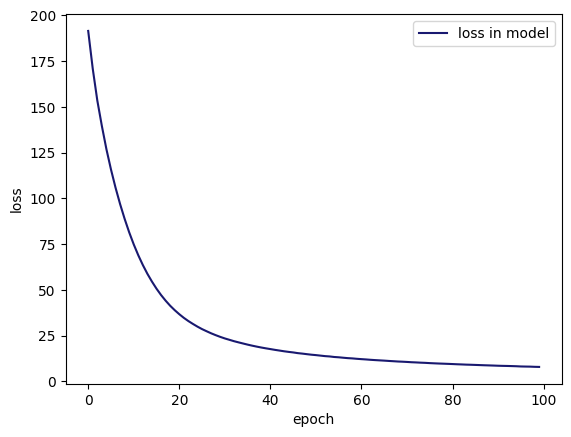

In [46]:
plt.plot(loss_list,label='loss in model',color='midnightblue')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

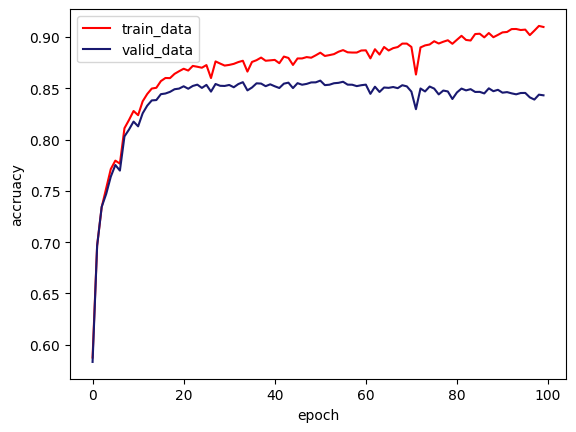

In [47]:
plt.plot(train_acc_list,label='train_data',color='red')
plt.plot(valid_acc_list,label='valid_data',color='midnightblue')
plt.xlabel('epoch')
plt.ylabel('accruacy')
plt.legend()
plt.show()

In [ ]:
lembda_list=[1e-5,1e-4,1e-3,1e-2,1e-1,1,10,100,1000]
hidden_size=100
output_size=1
n_layers=1
embedding_dim=64
train_accuracy=[]
test_accuracy=[]
loss_train=[]
lr=0.0001
print('Process starts from here :::')
for i in range(len(lembda_list)):
    
    
    lembda=lembda_list[i]
    train_acc_list=[]
    valid_acc_list=[]
    
    


    
    
    model=RNN(hidden_size,output_size,n_layers,embedding_dim).to(device)
    criterion =nn.BCELoss()
   
    
    loss_list=[]
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    epochs=100
    num_epochs=tqdm(range(epochs))

    # n_epochs=tqdm(range(epochs))
    for epoch in num_epochs:

        running_loss = 0

        for i,(instances, labels) in enumerate(train_loader):

            optimizer.zero_grad()

            instances=instances.to(device)
            labels=labels.reshape(len(labels),-1).to(device).to(torch.float32)
            # print(instances.shape)
            output = model(instances)
            # manually regularization
            l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())/50

            #print(output)
            loss = criterion(output, labels)+lembda*l2_norm
            


            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        loss_list.append(running_loss/batch_size)
        a=train_acc(model)
        train_acc_list.append(a)
        
        b=valid_acc(model)
        
        # print('accuracy over validation data set:',b)
        valid_acc_list.append(b)
    train_accuracy.append(train_acc_list)
    test_accuracy.append(valid_acc_list)
    loss_train.append(loss_list)

    
dict_results={'lambdas':lembda_list,'train_accuracy':train_accuracy,'test_accuracy':test_accuracy,'loss_list':loss_train}

with open('/home/divya/sohan_p/RNN/RNN_L2.pkl', 'wb') as f:
    pickle.dump(dict_results, f)  
            

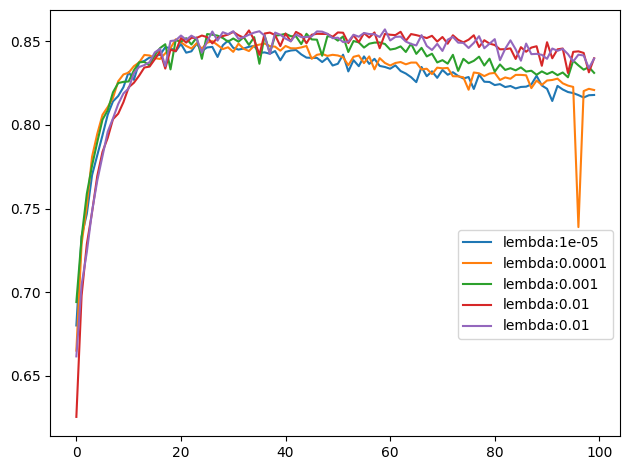

In [17]:
dict_results=pd.read_pickle('/home/divya/sohan_p/RNN/RNN_L2.pkl')
train_accuracy=dict_results['train_accuracy']
test_accuracy=dict_results['test_accuracy']
lembda_list=dict_results['lambdas']

for i in range(len(train_accuracy[:5])):
    # plt.plot(train_accuracy[i],label=f'over train data with lr:{lr_list[i]}')
    plt.plot(test_accuracy[i],label=f'lembda:{lembda_list[i]}')
plt.legend(bbox_to_anchor=(1,0.5))
plt.tight_layout()


$\large \text{Hence we can see that for L2 regularization lambda=0.01 works far enough.}$

$\huge \text{L1 Regularization:}$

In [16]:
hidden_size=100
output_size=1
n_layers=1
embedding_dim=64
lembda=0.01
model=RNN(hidden_size,output_size,n_layers,embedding_dim).to(device)
criterion =nn.BCELoss()
lr=0.0001
train_acc_list=[]
valid_acc_list=[]
loss_list=[]
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
epochs=100
num_epochs=tqdm(range(epochs))

# n_epochs=tqdm(range(epochs))
for epoch in num_epochs:

    running_loss = 0

    for i,(instances, labels) in enumerate(train_loader):

        optimizer.zero_grad()

        instances=instances.to(device)
        labels=labels.reshape(len(labels),-1).to(device).to(torch.float32)
        # print(instances.shape)
        output = model(instances)
        # manually regularization
        l1_norm = sum(p.abs().sum() for p in model.parameters())/50
        #print(output)
        loss = criterion(output, labels)+lembda*l1_norm
        


        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    loss_list.append(running_loss/batch_size)
    a=train_acc(model)
    train_acc_list.append(a)
    
    b=valid_acc(model)
    
    # print('accuracy over validation data set:',b)
    valid_acc_list.append(b)
    print('epoch is:',epoch+1,'accuracy over training/validation data set:',a,'/',b,' || running loss is:',running_loss/batch_size)
 


  1%|          | 1/100 [00:29<48:40, 29.50s/it]

epoch is: 1 accuracy over training/validation data set: 0.6426666666666667 / 0.64024  || running loss is: 159.2728520965576


  2%|▏         | 2/100 [00:58<47:55, 29.34s/it]

epoch is: 2 accuracy over training/validation data set: 0.7081066666666667 / 0.69944  || running loss is: 145.41889291763306


  3%|▎         | 3/100 [01:28<47:56, 29.65s/it]

epoch is: 3 accuracy over training/validation data set: 0.7288533333333334 / 0.72208  || running loss is: 135.10046262741088


  4%|▍         | 4/100 [01:58<47:28, 29.67s/it]

epoch is: 4 accuracy over training/validation data set: 0.7461866666666667 / 0.73616  || running loss is: 126.46873188018799


  5%|▌         | 5/100 [02:26<46:03, 29.09s/it]

epoch is: 5 accuracy over training/validation data set: 0.7632533333333333 / 0.75592  || running loss is: 118.86558859825135


  6%|▌         | 6/100 [02:54<44:53, 28.65s/it]

epoch is: 6 accuracy over training/validation data set: 0.77632 / 0.76584  || running loss is: 111.89988117218017


  7%|▋         | 7/100 [03:22<44:24, 28.66s/it]

epoch is: 7 accuracy over training/validation data set: 0.7821066666666666 / 0.76904  || running loss is: 105.52153503417969


  8%|▊         | 8/100 [03:51<44:00, 28.70s/it]

epoch is: 8 accuracy over training/validation data set: 0.7980266666666667 / 0.78872  || running loss is: 99.62665566444397


  9%|▉         | 9/100 [04:19<42:50, 28.25s/it]

epoch is: 9 accuracy over training/validation data set: 0.8034933333333333 / 0.7912  || running loss is: 94.15536493301391


 10%|█         | 10/100 [04:48<42:46, 28.52s/it]

epoch is: 10 accuracy over training/validation data set: 0.80968 / 0.80072  || running loss is: 89.10087869644165


 11%|█         | 11/100 [05:18<42:55, 28.94s/it]

epoch is: 11 accuracy over training/validation data set: 0.8152533333333334 / 0.8056  || running loss is: 84.43267040252685


 12%|█▏        | 12/100 [05:47<42:44, 29.14s/it]

epoch is: 12 accuracy over training/validation data set: 0.8228533333333333 / 0.81208  || running loss is: 80.05722865104676


 13%|█▎        | 13/100 [06:17<42:41, 29.44s/it]

epoch is: 13 accuracy over training/validation data set: 0.8249333333333333 / 0.8144  || running loss is: 76.01456155776978


 14%|█▍        | 14/100 [06:45<41:37, 29.04s/it]

epoch is: 14 accuracy over training/validation data set: 0.8269066666666667 / 0.81848  || running loss is: 72.26853296279907


 15%|█▌        | 15/100 [07:15<41:12, 29.09s/it]

epoch is: 15 accuracy over training/validation data set: 0.8315733333333334 / 0.822  || running loss is: 68.80936520576478


 16%|█▌        | 16/100 [07:43<40:37, 29.01s/it]

epoch is: 16 accuracy over training/validation data set: 0.83664 / 0.82488  || running loss is: 65.62519585609436


 17%|█▋        | 17/100 [08:12<40:01, 28.93s/it]

epoch is: 17 accuracy over training/validation data set: 0.83416 / 0.82016  || running loss is: 62.63936545848846


 18%|█▊        | 18/100 [08:41<39:29, 28.89s/it]

epoch is: 18 accuracy over training/validation data set: 0.83656 / 0.82208  || running loss is: 59.915293254852294


 19%|█▉        | 19/100 [09:10<39:04, 28.95s/it]

epoch is: 19 accuracy over training/validation data set: 0.8429066666666667 / 0.82896  || running loss is: 57.40976667881012


 20%|██        | 20/100 [09:35<37:11, 27.89s/it]

epoch is: 20 accuracy over training/validation data set: 0.8439733333333334 / 0.83168  || running loss is: 55.040568828582764


 21%|██        | 21/100 [10:00<35:19, 26.82s/it]

epoch is: 21 accuracy over training/validation data set: 0.8466666666666667 / 0.83264  || running loss is: 52.84789756774902


 22%|██▏       | 22/100 [10:25<34:15, 26.36s/it]

epoch is: 22 accuracy over training/validation data set: 0.84192 / 0.82568  || running loss is: 50.84779121398926


 23%|██▎       | 23/100 [10:53<34:27, 26.85s/it]

epoch is: 23 accuracy over training/validation data set: 0.8466666666666667 / 0.8352  || running loss is: 48.95834806442261


 24%|██▍       | 24/100 [11:21<34:17, 27.08s/it]

epoch is: 24 accuracy over training/validation data set: 0.8509066666666667 / 0.83552  || running loss is: 47.18834678173065


 25%|██▌       | 25/100 [11:47<33:23, 26.72s/it]

epoch is: 25 accuracy over training/validation data set: 0.8515466666666667 / 0.83568  || running loss is: 45.553510088920596


 26%|██▌       | 26/100 [12:12<32:32, 26.38s/it]

epoch is: 26 accuracy over training/validation data set: 0.8501333333333333 / 0.83704  || running loss is: 44.02625834941864


 27%|██▋       | 27/100 [12:36<31:20, 25.76s/it]

epoch is: 27 accuracy over training/validation data set: 0.8521866666666666 / 0.8384  || running loss is: 42.60001801490784


 28%|██▊       | 28/100 [13:00<29:57, 24.97s/it]

epoch is: 28 accuracy over training/validation data set: 0.8530133333333333 / 0.83536  || running loss is: 41.27787152767181


 29%|██▉       | 29/100 [13:24<29:17, 24.75s/it]

epoch is: 29 accuracy over training/validation data set: 0.8567466666666667 / 0.84112  || running loss is: 40.02911909580231


 30%|███       | 30/100 [13:49<28:57, 24.82s/it]

epoch is: 30 accuracy over training/validation data set: 0.85768 / 0.84264  || running loss is: 38.848002185821535


 31%|███       | 31/100 [14:14<28:35, 24.86s/it]

epoch is: 31 accuracy over training/validation data set: 0.8475733333333333 / 0.83296  || running loss is: 37.732207913398746


 32%|███▏      | 32/100 [14:41<28:51, 25.47s/it]

epoch is: 32 accuracy over training/validation data set: 0.8571733333333333 / 0.84392  || running loss is: 36.69929203987122


 33%|███▎      | 33/100 [15:08<29:08, 26.10s/it]

epoch is: 33 accuracy over training/validation data set: 0.8498666666666667 / 0.8388  || running loss is: 35.74528458595276


 34%|███▍      | 34/100 [15:36<29:14, 26.59s/it]

epoch is: 34 accuracy over training/validation data set: 0.85936 / 0.84632  || running loss is: 34.79987823009491


 35%|███▌      | 35/100 [16:03<29:04, 26.84s/it]

epoch is: 35 accuracy over training/validation data set: 0.8593333333333333 / 0.84376  || running loss is: 33.94585883140564


 36%|███▌      | 36/100 [16:31<28:53, 27.09s/it]

epoch is: 36 accuracy over training/validation data set: 0.8552266666666667 / 0.84192  || running loss is: 33.129589943885804


 37%|███▋      | 37/100 [17:00<28:59, 27.61s/it]

epoch is: 37 accuracy over training/validation data set: 0.858 / 0.84424  || running loss is: 32.32987662553787


 38%|███▊      | 38/100 [17:23<27:06, 26.23s/it]

epoch is: 38 accuracy over training/validation data set: 0.8590666666666666 / 0.84416  || running loss is: 31.59105059623718


 39%|███▉      | 39/100 [17:52<27:30, 27.06s/it]

epoch is: 39 accuracy over training/validation data set: 0.85912 / 0.84456  || running loss is: 30.886468601226806


 40%|████      | 40/100 [18:19<27:12, 27.20s/it]

epoch is: 40 accuracy over training/validation data set: 0.8565066666666666 / 0.84376  || running loss is: 30.201780886650084


 41%|████      | 41/100 [18:47<26:56, 27.39s/it]

epoch is: 41 accuracy over training/validation data set: 0.8588266666666666 / 0.844  || running loss is: 29.5692977809906


 42%|████▏     | 42/100 [19:16<26:53, 27.82s/it]

epoch is: 42 accuracy over training/validation data set: 0.8599466666666666 / 0.846  || running loss is: 28.968755145072937


 43%|████▎     | 43/100 [19:38<24:37, 25.93s/it]

epoch is: 43 accuracy over training/validation data set: 0.8574666666666667 / 0.84408  || running loss is: 28.41065846204758


 44%|████▍     | 44/100 [20:04<24:12, 25.95s/it]

epoch is: 44 accuracy over training/validation data set: 0.8617866666666667 / 0.84704  || running loss is: 27.853690094947815


 45%|████▌     | 45/100 [20:28<23:21, 25.48s/it]

epoch is: 45 accuracy over training/validation data set: 0.85544 / 0.84112  || running loss is: 27.360635902881622


 46%|████▌     | 46/100 [20:56<23:34, 26.19s/it]

epoch is: 46 accuracy over training/validation data set: 0.8646133333333333 / 0.84864  || running loss is: 26.821471650600433


 47%|████▋     | 47/100 [21:19<22:19, 25.28s/it]

epoch is: 47 accuracy over training/validation data set: 0.85728 / 0.84448  || running loss is: 26.35839616060257


 48%|████▊     | 48/100 [21:44<21:46, 25.13s/it]

epoch is: 48 accuracy over training/validation data set: 0.84792 / 0.83448  || running loss is: 25.897448427677155


 49%|████▉     | 49/100 [22:10<21:36, 25.43s/it]

epoch is: 49 accuracy over training/validation data set: 0.8636266666666667 / 0.84736  || running loss is: 25.483517134189604


 50%|█████     | 50/100 [22:34<20:51, 25.03s/it]

epoch is: 50 accuracy over training/validation data set: 0.8629866666666667 / 0.84816  || running loss is: 25.086814441680907


 51%|█████     | 51/100 [22:58<20:12, 24.74s/it]

epoch is: 51 accuracy over training/validation data set: 0.86232 / 0.84544  || running loss is: 24.625740430355073


 52%|█████▏    | 52/100 [23:23<19:44, 24.69s/it]

epoch is: 52 accuracy over training/validation data set: 0.86448 / 0.84952  || running loss is: 24.259696931838988


 53%|█████▎    | 53/100 [23:47<19:18, 24.65s/it]

epoch is: 53 accuracy over training/validation data set: 0.8631733333333333 / 0.84832  || running loss is: 23.914752373695375


 54%|█████▍    | 54/100 [24:14<19:18, 25.19s/it]

epoch is: 54 accuracy over training/validation data set: 0.8599466666666666 / 0.84912  || running loss is: 23.560452008247374


 55%|█████▌    | 55/100 [24:41<19:17, 25.72s/it]

epoch is: 55 accuracy over training/validation data set: 0.8478666666666667 / 0.83568  || running loss is: 23.205296120643617


 56%|█████▌    | 56/100 [25:08<19:12, 26.18s/it]

epoch is: 56 accuracy over training/validation data set: 0.8611733333333333 / 0.84744  || running loss is: 22.891740729808806


 57%|█████▋    | 57/100 [25:35<18:58, 26.47s/it]

epoch is: 57 accuracy over training/validation data set: 0.86184 / 0.8496  || running loss is: 22.587315566539765


 58%|█████▊    | 58/100 [26:03<18:50, 26.91s/it]

epoch is: 58 accuracy over training/validation data set: 0.8629333333333333 / 0.84896  || running loss is: 22.25825430393219


 59%|█████▉    | 59/100 [26:31<18:36, 27.24s/it]

epoch is: 59 accuracy over training/validation data set: 0.86504 / 0.84928  || running loss is: 21.973194839954377


 60%|██████    | 60/100 [26:59<18:19, 27.48s/it]

epoch is: 60 accuracy over training/validation data set: 0.8621866666666667 / 0.8484  || running loss is: 21.674588885307312


 61%|██████    | 61/100 [27:27<17:57, 27.63s/it]

epoch is: 61 accuracy over training/validation data set: 0.8631466666666666 / 0.85056  || running loss is: 21.418916399478913


 62%|██████▏   | 62/100 [27:54<17:27, 27.56s/it]

epoch is: 62 accuracy over training/validation data set: 0.8656266666666667 / 0.85032  || running loss is: 21.173611109256743


 63%|██████▎   | 63/100 [28:22<17:01, 27.61s/it]

epoch is: 63 accuracy over training/validation data set: 0.86584 / 0.84976  || running loss is: 20.89361217021942


 64%|██████▍   | 64/100 [28:50<16:37, 27.71s/it]

epoch is: 64 accuracy over training/validation data set: 0.86592 / 0.85  || running loss is: 20.694665412902832


 65%|██████▌   | 65/100 [29:18<16:11, 27.76s/it]

epoch is: 65 accuracy over training/validation data set: 0.8621066666666667 / 0.84784  || running loss is: 20.441431884765624


 66%|██████▌   | 66/100 [29:45<15:35, 27.52s/it]

epoch is: 66 accuracy over training/validation data set: 0.8669333333333333 / 0.85208  || running loss is: 20.215320632457733


 67%|██████▋   | 67/100 [30:12<15:04, 27.40s/it]

epoch is: 67 accuracy over training/validation data set: 0.8658666666666667 / 0.85144  || running loss is: 19.971726026535034


 68%|██████▊   | 68/100 [30:39<14:36, 27.39s/it]

epoch is: 68 accuracy over training/validation data set: 0.86568 / 0.85168  || running loss is: 19.770351042747496


 69%|██████▉   | 69/100 [31:05<13:56, 26.98s/it]

epoch is: 69 accuracy over training/validation data set: 0.8650133333333333 / 0.84944  || running loss is: 19.554491105079652


 70%|███████   | 70/100 [31:33<13:31, 27.06s/it]

epoch is: 70 accuracy over training/validation data set: 0.8645066666666666 / 0.85048  || running loss is: 19.337358906269074


 71%|███████   | 71/100 [32:00<13:09, 27.21s/it]

epoch is: 71 accuracy over training/validation data set: 0.8652533333333333 / 0.84888  || running loss is: 19.17176731109619


 72%|███████▏  | 72/100 [32:27<12:40, 27.17s/it]

epoch is: 72 accuracy over training/validation data set: 0.8669333333333333 / 0.85016  || running loss is: 18.964896998405457


 73%|███████▎  | 73/100 [32:55<12:20, 27.42s/it]

epoch is: 73 accuracy over training/validation data set: 0.8640266666666667 / 0.84968  || running loss is: 18.794639127254484


 74%|███████▍  | 74/100 [33:24<11:59, 27.68s/it]

epoch is: 74 accuracy over training/validation data set: 0.8622933333333334 / 0.84896  || running loss is: 18.607543561458588


 75%|███████▌  | 75/100 [33:52<11:37, 27.88s/it]

epoch is: 75 accuracy over training/validation data set: 0.8644266666666667 / 0.8504  || running loss is: 18.432249517440795


 76%|███████▌  | 76/100 [34:19<11:06, 27.78s/it]

epoch is: 76 accuracy over training/validation data set: 0.8676266666666667 / 0.85272  || running loss is: 18.255467739105224


 77%|███████▋  | 77/100 [34:46<10:31, 27.48s/it]

epoch is: 77 accuracy over training/validation data set: 0.8656266666666667 / 0.85088  || running loss is: 18.1069335103035


 78%|███████▊  | 78/100 [35:14<10:08, 27.67s/it]

epoch is: 78 accuracy over training/validation data set: 0.8561333333333333 / 0.84312  || running loss is: 17.937437846660615


 79%|███████▉  | 79/100 [35:39<09:19, 26.66s/it]

epoch is: 79 accuracy over training/validation data set: 0.8677866666666667 / 0.8524  || running loss is: 17.78001684308052


 80%|████████  | 80/100 [36:04<08:44, 26.21s/it]

epoch is: 80 accuracy over training/validation data set: 0.8584533333333333 / 0.84544  || running loss is: 17.639060723781586


 81%|████████  | 81/100 [36:29<08:12, 25.93s/it]

epoch is: 81 accuracy over training/validation data set: 0.86704 / 0.85376  || running loss is: 17.481284228563307


 82%|████████▏ | 82/100 [36:55<07:45, 25.85s/it]

epoch is: 82 accuracy over training/validation data set: 0.86536 / 0.8508  || running loss is: 17.32620113134384


 83%|████████▎ | 83/100 [37:21<07:23, 26.08s/it]

epoch is: 83 accuracy over training/validation data set: 0.85808 / 0.84472  || running loss is: 17.1963445520401


 84%|████████▍ | 84/100 [37:49<07:04, 26.54s/it]

epoch is: 84 accuracy over training/validation data set: 0.8634933333333333 / 0.84864  || running loss is: 17.071511580944062


 85%|████████▌ | 85/100 [38:18<06:51, 27.42s/it]

epoch is: 85 accuracy over training/validation data set: 0.8649066666666667 / 0.85216  || running loss is: 16.918096758127213


 86%|████████▌ | 86/100 [38:46<06:26, 27.58s/it]

epoch is: 86 accuracy over training/validation data set: 0.8648533333333334 / 0.85208  || running loss is: 16.78205908060074


 87%|████████▋ | 87/100 [39:14<05:57, 27.48s/it]

epoch is: 87 accuracy over training/validation data set: 0.8649866666666667 / 0.85184  || running loss is: 16.682973251342773


 88%|████████▊ | 88/100 [39:40<05:27, 27.27s/it]

epoch is: 88 accuracy over training/validation data set: 0.8624 / 0.8484  || running loss is: 16.530365182161333


 89%|████████▉ | 89/100 [40:07<04:59, 27.21s/it]

epoch is: 89 accuracy over training/validation data set: 0.8632 / 0.8488  || running loss is: 16.428271809816362


 90%|█████████ | 90/100 [40:33<04:28, 26.84s/it]

epoch is: 90 accuracy over training/validation data set: 0.86576 / 0.8524  || running loss is: 16.305180633068083


 91%|█████████ | 91/100 [41:01<04:02, 26.94s/it]

epoch is: 91 accuracy over training/validation data set: 0.8642666666666666 / 0.8512  || running loss is: 16.183943465948104


 92%|█████████▏| 92/100 [41:28<03:36, 27.07s/it]

epoch is: 92 accuracy over training/validation data set: 0.86736 / 0.85424  || running loss is: 16.066832380294798


 93%|█████████▎| 93/100 [41:56<03:11, 27.32s/it]

epoch is: 93 accuracy over training/validation data set: 0.8685066666666666 / 0.85312  || running loss is: 15.966281542778015


 94%|█████████▍| 94/100 [42:24<02:45, 27.52s/it]

epoch is: 94 accuracy over training/validation data set: 0.8656 / 0.852  || running loss is: 15.849977923631668


 95%|█████████▌| 95/100 [42:52<02:17, 27.56s/it]

epoch is: 95 accuracy over training/validation data set: 0.8681333333333333 / 0.85192  || running loss is: 15.75447016954422


 96%|█████████▌| 96/100 [43:20<01:51, 27.78s/it]

epoch is: 96 accuracy over training/validation data set: 0.8633333333333333 / 0.8512  || running loss is: 15.649747748374939


 97%|█████████▋| 97/100 [43:48<01:23, 27.88s/it]

epoch is: 97 accuracy over training/validation data set: 0.8664266666666667 / 0.85216  || running loss is: 15.534578384160996


 98%|█████████▊| 98/100 [44:16<00:55, 27.85s/it]

epoch is: 98 accuracy over training/validation data set: 0.8654133333333334 / 0.85264  || running loss is: 15.425052125453949


 99%|█████████▉| 99/100 [44:41<00:27, 27.16s/it]

epoch is: 99 accuracy over training/validation data set: 0.86808 / 0.85256  || running loss is: 15.347162243127823


100%|██████████| 100/100 [45:06<00:00, 27.06s/it]

epoch is: 100 accuracy over training/validation data set: 0.86816 / 0.8532  || running loss is: 15.260923165082932


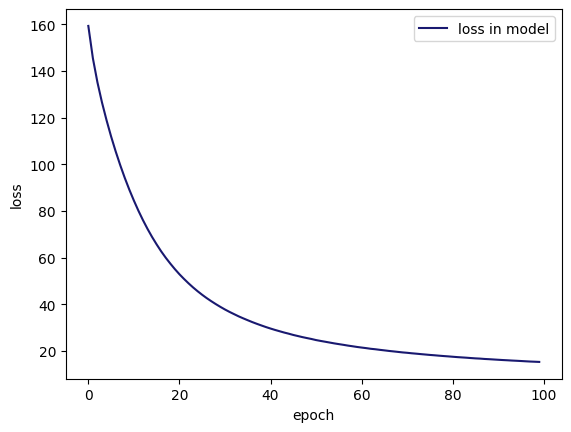

In [17]:
plt.plot(loss_list,label='loss in model',color='midnightblue')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

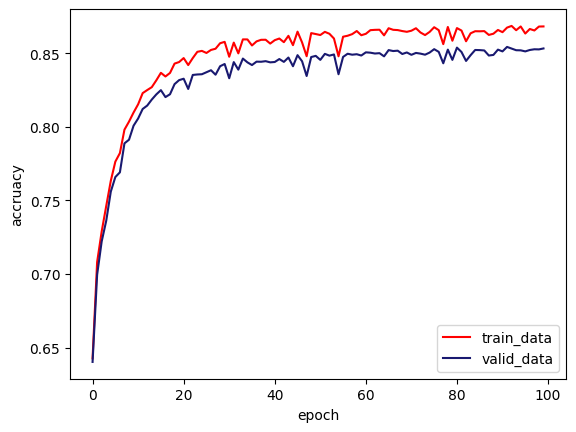

In [18]:
plt.plot(train_acc_list,label='train_data',color='red')
plt.plot(valid_acc_list,label='valid_data',color='midnightblue')
plt.xlabel('epoch')
plt.ylabel('accruacy')
plt.legend()
plt.show()

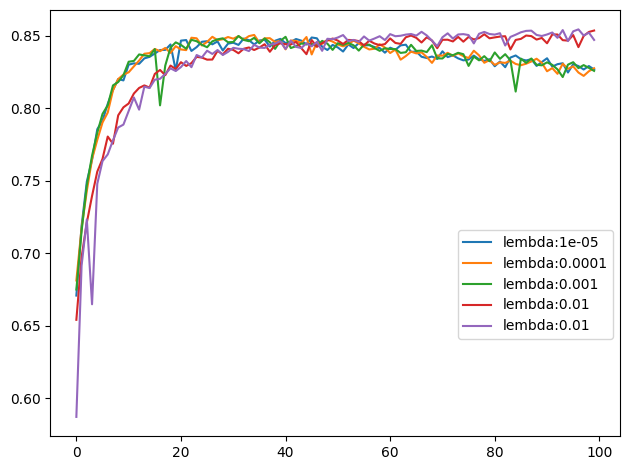

In [18]:
dict_results=pd.read_pickle('/home/divya/sohan_p/RNN/RNN_L1.pkl')
train_accuracy=dict_results['train_accuracy']
test_accuracy=dict_results['test_accuracy']
lembda_list=dict_results['lambdas']

for i in range(len(train_accuracy[:5])):
    # plt.plot(train_accuracy[i],label=f'over train data with lr:{lr_list[i]}')
    plt.plot(test_accuracy[i],label=f'lembda:{lembda_list[i]}')
plt.legend(bbox_to_anchor=(1,0.5))
plt.tight_layout()


$\large \text{Weight Decay:}$

In [19]:
hidden_size=100
output_size=1
n_layers=1
embedding_dim=64
lembda=0.01
model=RNN(hidden_size,output_size,n_layers,embedding_dim).to(device)
criterion =nn.BCELoss()
lr=0.0001
train_acc_list=[]
valid_acc_list=[]
loss_list=[]
optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay=lembda)
epochs=100
num_epochs=tqdm(range(epochs))

# n_epochs=tqdm(range(epochs))
for epoch in num_epochs:

    running_loss = 0

    for i,(instances, labels) in enumerate(train_loader):

        optimizer.zero_grad()

        instances=instances.to(device)
        labels=labels.reshape(len(labels),-1).to(device).to(torch.float32)
        # print(instances.shape)
        output = model(instances)
        #print(output)
        loss = criterion(output, labels)
        


        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    loss_list.append(running_loss/batch_size)
    a=train_acc(model)
    train_acc_list.append(a)
    
    b=valid_acc(model)
    
    # print('accuracy over validation data set:',b)
    valid_acc_list.append(b)
    print('epoch is:',epoch+1,'accuracy over training/validation data set:',a,'/',b,' || running loss is:',running_loss/batch_size)
 


  1%|          | 1/100 [00:26<43:30, 26.37s/it]

epoch is: 1 accuracy over training/validation data set: 0.5697333333333333 / 0.56728  || running loss is: 10.344573162794113


  2%|▏         | 2/100 [00:52<42:58, 26.32s/it]

epoch is: 2 accuracy over training/validation data set: 0.66384 / 0.67128  || running loss is: 9.666256504058838


  3%|▎         | 3/100 [01:18<42:15, 26.14s/it]

epoch is: 3 accuracy over training/validation data set: 0.6830133333333334 / 0.6872  || running loss is: 9.136041933894157


  4%|▍         | 4/100 [01:45<42:28, 26.54s/it]

epoch is: 4 accuracy over training/validation data set: 0.6905066666666667 / 0.69384  || running loss is: 8.96485255599022


  5%|▌         | 5/100 [02:11<41:43, 26.35s/it]

epoch is: 5 accuracy over training/validation data set: 0.69256 / 0.69544  || running loss is: 8.905972685813904


  6%|▌         | 6/100 [02:36<40:34, 25.90s/it]

epoch is: 6 accuracy over training/validation data set: 0.69496 / 0.69728  || running loss is: 8.828805927634239


  7%|▋         | 7/100 [03:03<40:35, 26.19s/it]

epoch is: 7 accuracy over training/validation data set: 0.7030133333333334 / 0.70536  || running loss is: 8.761355856060982


  8%|▊         | 8/100 [03:30<40:26, 26.38s/it]

epoch is: 8 accuracy over training/validation data set: 0.70776 / 0.7084  || running loss is: 8.69924502313137


  9%|▉         | 9/100 [03:56<40:03, 26.41s/it]

epoch is: 9 accuracy over training/validation data set: 0.71128 / 0.7128  || running loss is: 8.608132990598678


 10%|█         | 10/100 [04:23<39:51, 26.58s/it]

epoch is: 10 accuracy over training/validation data set: 0.7136533333333334 / 0.7156  || running loss is: 8.524869766831397


 11%|█         | 11/100 [04:49<39:14, 26.45s/it]

epoch is: 11 accuracy over training/validation data set: 0.722 / 0.72376  || running loss is: 8.414491359591484


 12%|█▏        | 12/100 [05:17<39:07, 26.68s/it]

epoch is: 12 accuracy over training/validation data set: 0.7248266666666666 / 0.72536  || running loss is: 8.271469460725784


 13%|█▎        | 13/100 [05:43<38:32, 26.58s/it]

epoch is: 13 accuracy over training/validation data set: 0.7333866666666666 / 0.73344  || running loss is: 8.121205141544342


 14%|█▍        | 14/100 [06:09<37:56, 26.47s/it]

epoch is: 14 accuracy over training/validation data set: 0.74584 / 0.746  || running loss is: 7.971942721605301


 15%|█▌        | 15/100 [06:32<35:50, 25.30s/it]

epoch is: 15 accuracy over training/validation data set: 0.75456 / 0.75192  || running loss is: 7.750441130995751


 16%|█▌        | 16/100 [06:54<34:10, 24.41s/it]

epoch is: 16 accuracy over training/validation data set: 0.76728 / 0.76632  || running loss is: 7.547674198150634


 17%|█▋        | 17/100 [07:18<33:38, 24.32s/it]

epoch is: 17 accuracy over training/validation data set: 0.7706933333333333 / 0.7676  || running loss is: 7.31557872235775


 18%|█▊        | 18/100 [07:44<33:45, 24.70s/it]

epoch is: 18 accuracy over training/validation data set: 0.79056 / 0.78384  || running loss is: 7.0793198812007905


 19%|█▉        | 19/100 [08:10<34:04, 25.24s/it]

epoch is: 19 accuracy over training/validation data set: 0.7981866666666667 / 0.79144  || running loss is: 6.853228628933429


 20%|██        | 20/100 [08:36<33:49, 25.37s/it]

epoch is: 20 accuracy over training/validation data set: 0.80984 / 0.79984  || running loss is: 6.615121491551399


 21%|██        | 21/100 [09:00<32:49, 24.94s/it]

epoch is: 21 accuracy over training/validation data set: 0.81592 / 0.80928  || running loss is: 6.374883946478366


 22%|██▏       | 22/100 [09:22<31:13, 24.02s/it]

epoch is: 22 accuracy over training/validation data set: 0.8221066666666667 / 0.81152  || running loss is: 6.185052203536034


 23%|██▎       | 23/100 [09:46<31:03, 24.20s/it]

epoch is: 23 accuracy over training/validation data set: 0.8325333333333333 / 0.82504  || running loss is: 5.977841685116291


 24%|██▍       | 24/100 [10:12<31:09, 24.60s/it]

epoch is: 24 accuracy over training/validation data set: 0.8394933333333333 / 0.832  || running loss is: 5.838635377883911


 25%|██▌       | 25/100 [10:36<30:42, 24.56s/it]

epoch is: 25 accuracy over training/validation data set: 0.84512 / 0.83688  || running loss is: 5.678188806772232


 26%|██▌       | 26/100 [11:03<31:02, 25.16s/it]

epoch is: 26 accuracy over training/validation data set: 0.84976 / 0.8396  || running loss is: 5.511404181718826


 27%|██▋       | 27/100 [11:26<29:46, 24.47s/it]

epoch is: 27 accuracy over training/validation data set: 0.85472 / 0.84576  || running loss is: 5.397840829491615


 28%|██▊       | 28/100 [11:51<29:26, 24.54s/it]

epoch is: 28 accuracy over training/validation data set: 0.8390933333333334 / 0.8312  || running loss is: 5.272765906453133


 29%|██▉       | 29/100 [12:15<28:51, 24.39s/it]

epoch is: 29 accuracy over training/validation data set: 0.8577333333333333 / 0.84544  || running loss is: 5.224856455028057


 30%|███       | 30/100 [12:39<28:31, 24.45s/it]

epoch is: 30 accuracy over training/validation data set: 0.8566133333333333 / 0.84656  || running loss is: 5.1078424662351605


 31%|███       | 31/100 [13:05<28:41, 24.95s/it]

epoch is: 31 accuracy over training/validation data set: 0.86384 / 0.8536  || running loss is: 5.0700761833786965


 32%|███▏      | 32/100 [13:31<28:37, 25.26s/it]

epoch is: 32 accuracy over training/validation data set: 0.86816 / 0.8564  || running loss is: 5.0457680657505986


 33%|███▎      | 33/100 [13:58<28:36, 25.63s/it]

epoch is: 33 accuracy over training/validation data set: 0.8587466666666667 / 0.84896  || running loss is: 5.034141828119755


 34%|███▍      | 34/100 [14:24<28:21, 25.78s/it]

epoch is: 34 accuracy over training/validation data set: 0.8670133333333333 / 0.85544  || running loss is: 5.004960458874702


 35%|███▌      | 35/100 [14:51<28:14, 26.07s/it]

epoch is: 35 accuracy over training/validation data set: 0.8686933333333333 / 0.85504  || running loss is: 4.998561142086983


 36%|███▌      | 36/100 [15:17<27:51, 26.11s/it]

epoch is: 36 accuracy over training/validation data set: 0.8577333333333333 / 0.84896  || running loss is: 4.991698768138885


 37%|███▋      | 37/100 [15:44<27:37, 26.32s/it]

epoch is: 37 accuracy over training/validation data set: 0.86888 / 0.85304  || running loss is: 4.9677821514010425


 38%|███▊      | 38/100 [16:11<27:21, 26.48s/it]

epoch is: 38 accuracy over training/validation data set: 0.8679466666666666 / 0.85608  || running loss is: 4.94347680658102


 39%|███▉      | 39/100 [16:37<26:58, 26.54s/it]

epoch is: 39 accuracy over training/validation data set: 0.8709866666666667 / 0.85984  || running loss is: 4.967455113381147


 40%|████      | 40/100 [17:04<26:30, 26.51s/it]

epoch is: 40 accuracy over training/validation data set: 0.8648266666666666 / 0.8536  || running loss is: 4.975403194725513


 41%|████      | 41/100 [17:31<26:17, 26.75s/it]

epoch is: 41 accuracy over training/validation data set: 0.8541066666666667 / 0.84536  || running loss is: 4.9499204230308536


 42%|████▏     | 42/100 [17:58<25:51, 26.75s/it]

epoch is: 42 accuracy over training/validation data set: 0.8636266666666667 / 0.85472  || running loss is: 4.9400544606149195


 43%|████▎     | 43/100 [18:22<24:49, 26.12s/it]

epoch is: 43 accuracy over training/validation data set: 0.8649066666666667 / 0.85376  || running loss is: 4.937960987687111


 44%|████▍     | 44/100 [18:47<23:56, 25.65s/it]

epoch is: 44 accuracy over training/validation data set: 0.8602933333333334 / 0.85016  || running loss is: 4.986317025125027


 45%|████▌     | 45/100 [19:10<22:55, 25.01s/it]

epoch is: 45 accuracy over training/validation data set: 0.87064 / 0.85832  || running loss is: 4.938552601486444


 46%|████▌     | 46/100 [19:32<21:31, 23.91s/it]

epoch is: 46 accuracy over training/validation data set: 0.87104 / 0.85688  || running loss is: 4.947359981238842


 47%|████▋     | 47/100 [19:55<20:56, 23.71s/it]

epoch is: 47 accuracy over training/validation data set: 0.8633333333333333 / 0.85424  || running loss is: 4.932702301591635


 48%|████▊     | 48/100 [20:19<20:43, 23.91s/it]

epoch is: 48 accuracy over training/validation data set: 0.8696 / 0.85688  || running loss is: 4.907520749568939


 49%|████▉     | 49/100 [20:45<20:40, 24.31s/it]

epoch is: 49 accuracy over training/validation data set: 0.85688 / 0.8476  || running loss is: 4.995495583117008


 50%|█████     | 50/100 [21:08<19:54, 23.89s/it]

epoch is: 50 accuracy over training/validation data set: 0.86776 / 0.85624  || running loss is: 4.929742417037487


 51%|█████     | 51/100 [21:35<20:22, 24.94s/it]

epoch is: 51 accuracy over training/validation data set: 0.866 / 0.85216  || running loss is: 4.9003899165987965


 52%|█████▏    | 52/100 [22:03<20:40, 25.85s/it]

epoch is: 52 accuracy over training/validation data set: 0.8677333333333334 / 0.8552  || running loss is: 4.949996072798967


 53%|█████▎    | 53/100 [22:31<20:43, 26.46s/it]

epoch is: 53 accuracy over training/validation data set: 0.8625066666666666 / 0.85216  || running loss is: 4.930050673484803


 54%|█████▍    | 54/100 [22:58<20:21, 26.56s/it]

epoch is: 54 accuracy over training/validation data set: 0.86304 / 0.8512  || running loss is: 4.919322073459625


 55%|█████▌    | 55/100 [23:24<19:57, 26.60s/it]

epoch is: 55 accuracy over training/validation data set: 0.8645333333333334 / 0.85128  || running loss is: 4.933889868855476


 56%|█████▌    | 56/100 [23:49<19:11, 26.16s/it]

epoch is: 56 accuracy over training/validation data set: 0.8719466666666666 / 0.85712  || running loss is: 4.9296360623836515


 57%|█████▋    | 57/100 [24:13<18:16, 25.50s/it]

epoch is: 57 accuracy over training/validation data set: 0.86736 / 0.8564  || running loss is: 4.926814316362143


 58%|█████▊    | 58/100 [24:35<17:07, 24.47s/it]

epoch is: 58 accuracy over training/validation data set: 0.8672266666666667 / 0.85616  || running loss is: 4.916063270568848


 59%|█████▉    | 59/100 [24:59<16:30, 24.15s/it]

epoch is: 59 accuracy over training/validation data set: 0.8636533333333334 / 0.85384  || running loss is: 4.9205190017819405


 60%|██████    | 60/100 [25:25<16:31, 24.78s/it]

epoch is: 60 accuracy over training/validation data set: 0.8633333333333333 / 0.85112  || running loss is: 4.909069444835186


 61%|██████    | 61/100 [25:51<16:23, 25.22s/it]

epoch is: 61 accuracy over training/validation data set: 0.8649866666666667 / 0.85264  || running loss is: 4.9211015018820765


 62%|██████▏   | 62/100 [26:14<15:24, 24.32s/it]

epoch is: 62 accuracy over training/validation data set: 0.8675733333333333 / 0.85544  || running loss is: 4.926291786432266


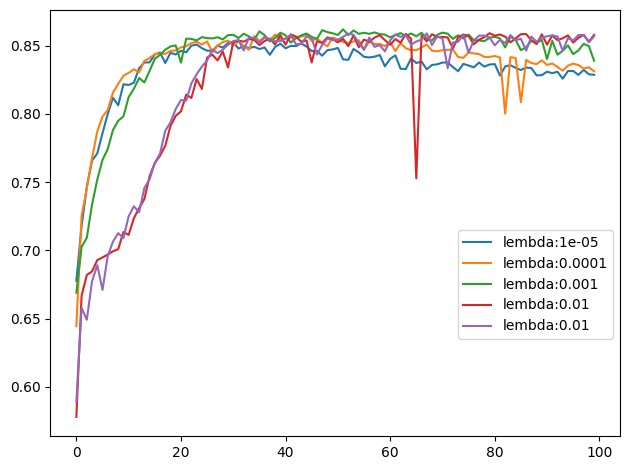

In [22]:
dict_results=pd.read_pickle('/home/divya/sohan_p/RNN/RNN_weightDacay.pkl')
train_accuracy=dict_results['train_accuracy']
test_accuracy=dict_results['test_accuracy']
lembda_list=dict_results['lambdas']

for i in range(len(train_accuracy[:5])):
    # plt.plot(train_accuracy[i],label=f'lembda:{lembda_list[i]}')
    plt.plot(test_accuracy[i],label=f'lembda:{lembda_list[i]}')
plt.legend(bbox_to_anchor=(1,0.5))
plt.tight_layout()
